# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = 'data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

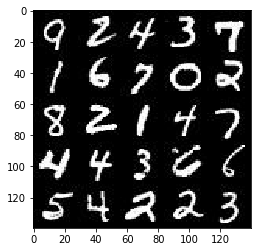

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

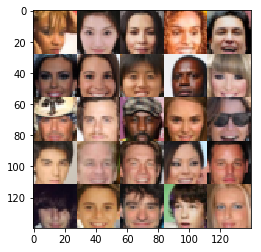

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input_images')
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_data')
    learningRate = tf.placeholder(tf.float32, name='learning_rate') 

    
    return real_input_images, z_data, learningRate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [50]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha= 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        dropout_layer = tf.layers.dropout(inputs=flat, rate=0.75)
        logits = tf.layers.dense(dropout_layer, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [51]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 2x2x104 now
        
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 4x4x512 now
        x3 = tf.layers.conv2d_transpose(x2, 256, 4, strides=1, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        x4 = tf.layers.conv2d_transpose(x3, 256, 4, strides=1, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
                                           
                                           
        x5 = tf.layers.conv2d_transpose(x4, 128, 4, strides=2, padding='same')
        x5 = tf.layers.batch_normalization(x5, training=is_train)
        x5 = tf.maximum(alpha * x5, x5)
        
        x6 = tf.layers.conv2d_transpose(x5, 128, 1, strides=1, padding='same')
        x6 = tf.layers.batch_normalization(x6, training=is_train)
        x6 = tf.maximum(alpha * x6, x6)
                                           
        
                                           
                                           
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x6, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
        
    
    return out 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [52]:
def model_loss(input_real, input_z, out_channel_dim, smooth =0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real,)
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)
    
    d_loss_real = tf.reduce_mean( 
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels= tf.ones_like(d_model_real)*(1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [53]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [54]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [55]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    #sample_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

    samples, losses = [], []
    steps = 0
    print_every = 10
    show_every = 100
    n_images = 9

    # Inputs
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # Loss
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    # Optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_images = 2*batch_images

                #Step 1. Random Noise to feed into G
                batch_z = np.random.uniform(-1, 1, size=(batch_size,z_dim))

                #Step 2. Run Optimizers
                # _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr : learning_rate, beta1: beta1})
                #_ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: get_batches, lr : learning_rate, beta1 : beta1})

                _ = sess.run(d_opt, feed_dict={input_real:batch_images, input_z: batch_z, lr : learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z:batch_z, input_real: batch_images, lr : learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Step{}".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess,n_images=9,input_z=input_z,out_channel_dim=data_shape[3],image_mode=data_image_mode)

       

  

    return losses, samples       

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Step10 Epoch 1/2... Discriminator Loss: 0.5407... Generator Loss: 4.0790
Step20 Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 3.3146
Step30 Epoch 1/2... Discriminator Loss: 2.0878... Generator Loss: 3.1806
Step40 Epoch 1/2... Discriminator Loss: 1.7692... Generator Loss: 2.4183
Step50 Epoch 1/2... Discriminator Loss: 1.8327... Generator Loss: 2.7308
Step60 Epoch 1/2... Discriminator Loss: 1.1576... Generator Loss: 2.6591
Step70 Epoch 1/2... Discriminator Loss: 0.8943... Generator Loss: 2.3007
Step80 Epoch 1/2... Discriminator Loss: 1.0217... Generator Loss: 3.5669
Step90 Epoch 1/2... Discriminator Loss: 0.6957... Generator Loss: 2.7871
Step100 Epoch 1/2... Discriminator Loss: 1.1134... Generator Loss: 0.8452


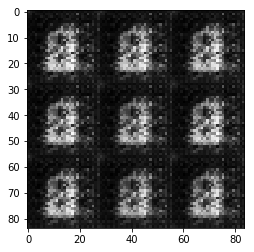

Step110 Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.9383
Step120 Epoch 1/2... Discriminator Loss: 0.7958... Generator Loss: 1.1889
Step130 Epoch 1/2... Discriminator Loss: 0.7273... Generator Loss: 1.3288
Step140 Epoch 1/2... Discriminator Loss: 0.6986... Generator Loss: 3.0623
Step150 Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 7.0498
Step160 Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 1.0221
Step170 Epoch 1/2... Discriminator Loss: 0.5680... Generator Loss: 2.5156
Step180 Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 2.9416
Step190 Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.9631
Step200 Epoch 1/2... Discriminator Loss: 0.6900... Generator Loss: 3.4906


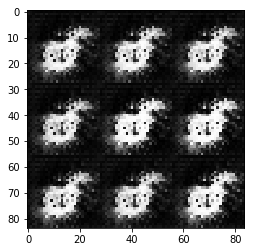

Step210 Epoch 1/2... Discriminator Loss: 0.6248... Generator Loss: 3.5327
Step220 Epoch 1/2... Discriminator Loss: 1.1107... Generator Loss: 4.7521
Step230 Epoch 1/2... Discriminator Loss: 0.5367... Generator Loss: 2.1395
Step240 Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 2.4307
Step250 Epoch 1/2... Discriminator Loss: 3.1876... Generator Loss: 0.0687
Step260 Epoch 1/2... Discriminator Loss: 0.8372... Generator Loss: 1.6658
Step270 Epoch 1/2... Discriminator Loss: 0.7761... Generator Loss: 1.3474
Step280 Epoch 1/2... Discriminator Loss: 0.6395... Generator Loss: 1.7341
Step290 Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.5648
Step300 Epoch 1/2... Discriminator Loss: 0.7834... Generator Loss: 1.1307


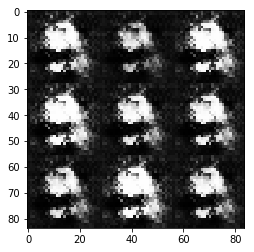

Step310 Epoch 1/2... Discriminator Loss: 0.7156... Generator Loss: 1.6585
Step320 Epoch 1/2... Discriminator Loss: 0.6932... Generator Loss: 1.8797
Step330 Epoch 1/2... Discriminator Loss: 0.9976... Generator Loss: 1.1078
Step340 Epoch 1/2... Discriminator Loss: 0.7769... Generator Loss: 1.4161
Step350 Epoch 1/2... Discriminator Loss: 0.7291... Generator Loss: 1.4558
Step360 Epoch 1/2... Discriminator Loss: 0.9259... Generator Loss: 6.5840
Step370 Epoch 1/2... Discriminator Loss: 0.8085... Generator Loss: 2.5432
Step380 Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.2038
Step390 Epoch 1/2... Discriminator Loss: 0.6303... Generator Loss: 1.8601
Step400 Epoch 1/2... Discriminator Loss: 1.3063... Generator Loss: 0.5678


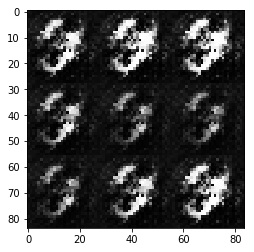

Step410 Epoch 1/2... Discriminator Loss: 0.7954... Generator Loss: 1.7410
Step420 Epoch 1/2... Discriminator Loss: 0.7478... Generator Loss: 2.6330
Step430 Epoch 1/2... Discriminator Loss: 0.8007... Generator Loss: 4.1985
Step440 Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 0.7017
Step450 Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.3188
Step460 Epoch 1/2... Discriminator Loss: 0.5584... Generator Loss: 2.6928
Step470 Epoch 1/2... Discriminator Loss: 0.6076... Generator Loss: 1.9270
Step480 Epoch 1/2... Discriminator Loss: 0.5972... Generator Loss: 2.7864
Step490 Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.4034
Step500 Epoch 1/2... Discriminator Loss: 0.6800... Generator Loss: 1.4774


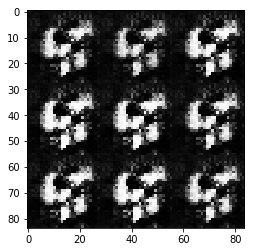

Step510 Epoch 1/2... Discriminator Loss: 0.7375... Generator Loss: 1.3943
Step520 Epoch 1/2... Discriminator Loss: 0.4420... Generator Loss: 3.7897
Step530 Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 2.1669
Step540 Epoch 1/2... Discriminator Loss: 0.5175... Generator Loss: 2.2251
Step550 Epoch 1/2... Discriminator Loss: 0.7705... Generator Loss: 1.3510
Step560 Epoch 1/2... Discriminator Loss: 0.6292... Generator Loss: 1.9722
Step570 Epoch 1/2... Discriminator Loss: 0.6733... Generator Loss: 2.4021
Step580 Epoch 1/2... Discriminator Loss: 1.2052... Generator Loss: 0.8625
Step590 Epoch 1/2... Discriminator Loss: 0.4775... Generator Loss: 2.7915
Step600 Epoch 1/2... Discriminator Loss: 0.6906... Generator Loss: 2.0487


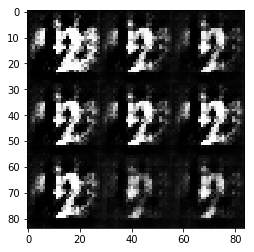

Step610 Epoch 1/2... Discriminator Loss: 1.7986... Generator Loss: 6.5384
Step620 Epoch 1/2... Discriminator Loss: 0.7918... Generator Loss: 1.7032
Step630 Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 2.1792
Step640 Epoch 1/2... Discriminator Loss: 0.7638... Generator Loss: 1.3093
Step650 Epoch 1/2... Discriminator Loss: 0.8111... Generator Loss: 1.4653
Step660 Epoch 1/2... Discriminator Loss: 0.7823... Generator Loss: 1.2313
Step670 Epoch 1/2... Discriminator Loss: 1.1369... Generator Loss: 0.9256
Step680 Epoch 1/2... Discriminator Loss: 0.6949... Generator Loss: 2.1241
Step690 Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 3.6505
Step700 Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 0.6979


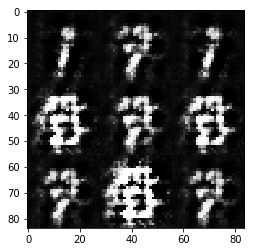

Step710 Epoch 1/2... Discriminator Loss: 0.7110... Generator Loss: 1.6173
Step720 Epoch 1/2... Discriminator Loss: 0.6910... Generator Loss: 2.3943
Step730 Epoch 1/2... Discriminator Loss: 0.6390... Generator Loss: 2.7167
Step740 Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.6554
Step750 Epoch 1/2... Discriminator Loss: 0.8982... Generator Loss: 1.4197
Step760 Epoch 1/2... Discriminator Loss: 0.7240... Generator Loss: 1.6480
Step770 Epoch 1/2... Discriminator Loss: 0.7666... Generator Loss: 1.4779
Step780 Epoch 1/2... Discriminator Loss: 0.5819... Generator Loss: 2.3057
Step790 Epoch 1/2... Discriminator Loss: 1.1333... Generator Loss: 4.4116
Step800 Epoch 1/2... Discriminator Loss: 0.9274... Generator Loss: 1.1534


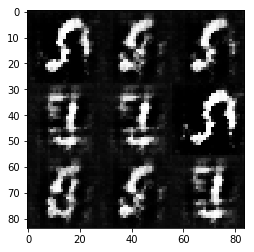

Step810 Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.2678
Step820 Epoch 1/2... Discriminator Loss: 0.9120... Generator Loss: 0.9759
Step830 Epoch 1/2... Discriminator Loss: 0.9010... Generator Loss: 2.0918
Step840 Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.0391
Step850 Epoch 1/2... Discriminator Loss: 1.1071... Generator Loss: 0.7153
Step860 Epoch 1/2... Discriminator Loss: 0.7862... Generator Loss: 1.3151
Step870 Epoch 1/2... Discriminator Loss: 0.6195... Generator Loss: 2.0272
Step880 Epoch 1/2... Discriminator Loss: 0.9531... Generator Loss: 1.4845
Step890 Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.8624
Step900 Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 1.1446


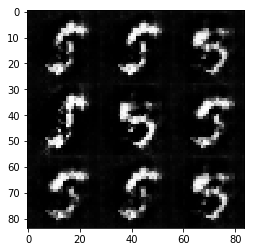

Step910 Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 0.5905
Step920 Epoch 1/2... Discriminator Loss: 0.7253... Generator Loss: 1.6337
Step930 Epoch 1/2... Discriminator Loss: 1.1339... Generator Loss: 0.9042
Step940 Epoch 1/2... Discriminator Loss: 0.9889... Generator Loss: 1.0394
Step950 Epoch 1/2... Discriminator Loss: 1.5484... Generator Loss: 4.0170
Step960 Epoch 1/2... Discriminator Loss: 0.9960... Generator Loss: 0.9162
Step970 Epoch 1/2... Discriminator Loss: 0.6703... Generator Loss: 1.6869
Step980 Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.4028
Step990 Epoch 1/2... Discriminator Loss: 0.6555... Generator Loss: 1.7849
Step1000 Epoch 1/2... Discriminator Loss: 0.8166... Generator Loss: 1.9449


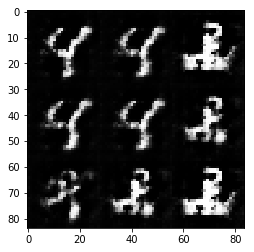

Step1010 Epoch 1/2... Discriminator Loss: 0.6782... Generator Loss: 1.6101
Step1020 Epoch 1/2... Discriminator Loss: 0.9988... Generator Loss: 2.9518
Step1030 Epoch 1/2... Discriminator Loss: 0.6255... Generator Loss: 1.9558
Step1040 Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.6947
Step1050 Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 2.4073
Step1060 Epoch 1/2... Discriminator Loss: 0.9127... Generator Loss: 1.1094
Step1070 Epoch 1/2... Discriminator Loss: 0.8808... Generator Loss: 1.1974
Step1080 Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 3.3437
Step1090 Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 2.2747
Step1100 Epoch 1/2... Discriminator Loss: 0.7148... Generator Loss: 1.8773


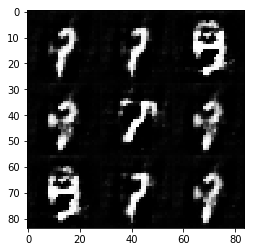

Step1110 Epoch 1/2... Discriminator Loss: 0.8006... Generator Loss: 1.8113
Step1120 Epoch 1/2... Discriminator Loss: 1.0443... Generator Loss: 3.5116
Step1130 Epoch 1/2... Discriminator Loss: 0.6584... Generator Loss: 1.8798
Step1140 Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.1248
Step1150 Epoch 1/2... Discriminator Loss: 0.7039... Generator Loss: 1.6643
Step1160 Epoch 1/2... Discriminator Loss: 0.9897... Generator Loss: 0.8354
Step1170 Epoch 1/2... Discriminator Loss: 0.7915... Generator Loss: 2.5260
Step1180 Epoch 1/2... Discriminator Loss: 1.1836... Generator Loss: 3.2946
Step1190 Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.7604
Step1200 Epoch 1/2... Discriminator Loss: 0.6169... Generator Loss: 2.3824


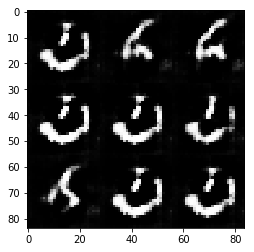

Step1210 Epoch 1/2... Discriminator Loss: 0.7442... Generator Loss: 1.5094
Step1220 Epoch 1/2... Discriminator Loss: 0.7782... Generator Loss: 1.5292
Step1230 Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.7914
Step1240 Epoch 1/2... Discriminator Loss: 0.6991... Generator Loss: 1.7832
Step1250 Epoch 1/2... Discriminator Loss: 0.7364... Generator Loss: 1.6834
Step1260 Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.2910
Step1270 Epoch 1/2... Discriminator Loss: 1.1628... Generator Loss: 0.9315
Step1280 Epoch 1/2... Discriminator Loss: 0.9987... Generator Loss: 0.9709
Step1290 Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 2.3198
Step1300 Epoch 1/2... Discriminator Loss: 0.9030... Generator Loss: 1.2563


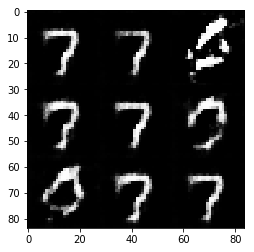

Step1310 Epoch 1/2... Discriminator Loss: 0.6316... Generator Loss: 2.8389
Step1320 Epoch 1/2... Discriminator Loss: 0.9460... Generator Loss: 1.0020
Step1330 Epoch 1/2... Discriminator Loss: 0.5959... Generator Loss: 2.8416
Step1340 Epoch 1/2... Discriminator Loss: 0.5710... Generator Loss: 2.3501
Step1350 Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.7893
Step1360 Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.1548
Step1370 Epoch 1/2... Discriminator Loss: 0.6999... Generator Loss: 2.8443
Step1380 Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.7632
Step1390 Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 3.7627
Step1400 Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.2080


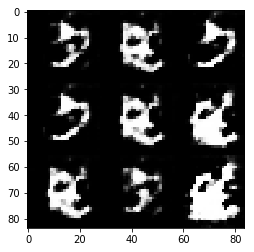

Step1410 Epoch 1/2... Discriminator Loss: 0.6887... Generator Loss: 3.6308
Step1420 Epoch 1/2... Discriminator Loss: 0.5617... Generator Loss: 2.3271
Step1430 Epoch 1/2... Discriminator Loss: 0.9461... Generator Loss: 0.9790
Step1440 Epoch 1/2... Discriminator Loss: 0.7789... Generator Loss: 1.3313
Step1450 Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 2.2112
Step1460 Epoch 1/2... Discriminator Loss: 0.6185... Generator Loss: 2.2374
Step1470 Epoch 1/2... Discriminator Loss: 0.9735... Generator Loss: 0.8476
Step1480 Epoch 1/2... Discriminator Loss: 0.7411... Generator Loss: 1.3382
Step1490 Epoch 1/2... Discriminator Loss: 0.5745... Generator Loss: 3.8461
Step1500 Epoch 1/2... Discriminator Loss: 0.6085... Generator Loss: 2.0617


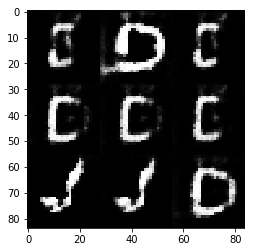

Step1510 Epoch 1/2... Discriminator Loss: 0.8361... Generator Loss: 2.4287
Step1520 Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.4833
Step1530 Epoch 1/2... Discriminator Loss: 0.5186... Generator Loss: 2.4855
Step1540 Epoch 1/2... Discriminator Loss: 0.6034... Generator Loss: 1.9674
Step1550 Epoch 1/2... Discriminator Loss: 0.6400... Generator Loss: 3.1450
Step1560 Epoch 1/2... Discriminator Loss: 0.8176... Generator Loss: 3.3642
Step1570 Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.6985
Step1580 Epoch 1/2... Discriminator Loss: 1.3179... Generator Loss: 0.8058
Step1590 Epoch 1/2... Discriminator Loss: 0.6082... Generator Loss: 3.6428
Step1600 Epoch 1/2... Discriminator Loss: 0.5154... Generator Loss: 2.2077


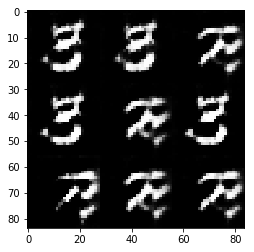

Step1610 Epoch 1/2... Discriminator Loss: 0.6494... Generator Loss: 1.5069
Step1620 Epoch 1/2... Discriminator Loss: 0.7321... Generator Loss: 2.4056
Step1630 Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.6979
Step1640 Epoch 1/2... Discriminator Loss: 0.8487... Generator Loss: 1.0415
Step1650 Epoch 1/2... Discriminator Loss: 0.7619... Generator Loss: 1.3638
Step1660 Epoch 1/2... Discriminator Loss: 0.6723... Generator Loss: 1.5601
Step1670 Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 1.1176
Step1680 Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 2.3466
Step1690 Epoch 1/2... Discriminator Loss: 0.9367... Generator Loss: 1.1733
Step1700 Epoch 1/2... Discriminator Loss: 0.7006... Generator Loss: 1.8138


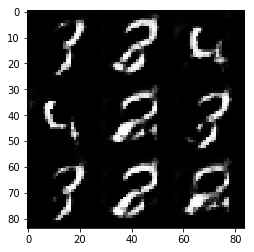

Step1710 Epoch 1/2... Discriminator Loss: 0.7354... Generator Loss: 1.9084
Step1720 Epoch 1/2... Discriminator Loss: 0.6612... Generator Loss: 1.6580
Step1730 Epoch 1/2... Discriminator Loss: 0.8339... Generator Loss: 1.6469
Step1740 Epoch 1/2... Discriminator Loss: 0.9575... Generator Loss: 1.1522
Step1750 Epoch 1/2... Discriminator Loss: 0.6371... Generator Loss: 1.7968
Step1760 Epoch 1/2... Discriminator Loss: 0.6940... Generator Loss: 2.7867
Step1770 Epoch 1/2... Discriminator Loss: 0.6247... Generator Loss: 1.7691
Step1780 Epoch 1/2... Discriminator Loss: 1.1620... Generator Loss: 0.7127
Step1790 Epoch 1/2... Discriminator Loss: 0.5571... Generator Loss: 2.4288
Step1800 Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 2.7895


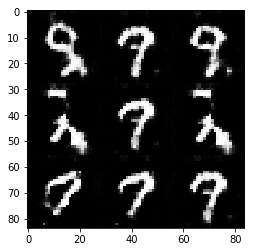

Step1810 Epoch 1/2... Discriminator Loss: 0.6444... Generator Loss: 1.9300
Step1820 Epoch 1/2... Discriminator Loss: 0.9270... Generator Loss: 3.9897
Step1830 Epoch 1/2... Discriminator Loss: 0.5813... Generator Loss: 2.0746
Step1840 Epoch 1/2... Discriminator Loss: 0.6446... Generator Loss: 2.6138
Step1850 Epoch 1/2... Discriminator Loss: 0.7378... Generator Loss: 2.2106
Step1860 Epoch 1/2... Discriminator Loss: 0.7031... Generator Loss: 1.8160
Step1870 Epoch 1/2... Discriminator Loss: 0.6499... Generator Loss: 2.0795
Step1880 Epoch 2/2... Discriminator Loss: 0.6116... Generator Loss: 1.7891
Step1890 Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.5163
Step1900 Epoch 2/2... Discriminator Loss: 0.7951... Generator Loss: 3.6964


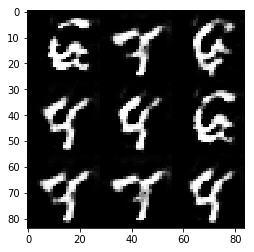

Step1910 Epoch 2/2... Discriminator Loss: 0.6024... Generator Loss: 2.3957
Step1920 Epoch 2/2... Discriminator Loss: 0.6324... Generator Loss: 1.8773
Step1930 Epoch 2/2... Discriminator Loss: 0.5127... Generator Loss: 2.0390
Step1940 Epoch 2/2... Discriminator Loss: 0.6207... Generator Loss: 3.5857
Step1950 Epoch 2/2... Discriminator Loss: 0.6724... Generator Loss: 1.5071
Step1960 Epoch 2/2... Discriminator Loss: 0.6094... Generator Loss: 1.7544
Step1970 Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.6744
Step1980 Epoch 2/2... Discriminator Loss: 0.5385... Generator Loss: 2.6382
Step1990 Epoch 2/2... Discriminator Loss: 1.1839... Generator Loss: 4.6930
Step2000 Epoch 2/2... Discriminator Loss: 0.7043... Generator Loss: 1.8500


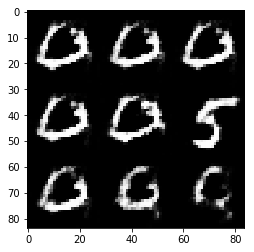

Step2010 Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 1.7623
Step2020 Epoch 2/2... Discriminator Loss: 0.6722... Generator Loss: 1.5324
Step2030 Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.0618
Step2040 Epoch 2/2... Discriminator Loss: 0.6618... Generator Loss: 1.7086
Step2050 Epoch 2/2... Discriminator Loss: 0.8871... Generator Loss: 1.4553
Step2060 Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 1.6454
Step2070 Epoch 2/2... Discriminator Loss: 0.7426... Generator Loss: 3.6448
Step2080 Epoch 2/2... Discriminator Loss: 0.6294... Generator Loss: 2.0265
Step2090 Epoch 2/2... Discriminator Loss: 0.5700... Generator Loss: 2.2166
Step2100 Epoch 2/2... Discriminator Loss: 0.5245... Generator Loss: 2.2208


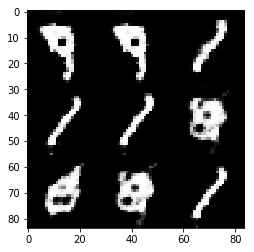

Step2110 Epoch 2/2... Discriminator Loss: 0.4968... Generator Loss: 2.6300
Step2120 Epoch 2/2... Discriminator Loss: 1.0065... Generator Loss: 0.9765
Step2130 Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 1.3561
Step2140 Epoch 2/2... Discriminator Loss: 0.5569... Generator Loss: 2.2369
Step2150 Epoch 2/2... Discriminator Loss: 0.8054... Generator Loss: 1.2671
Step2160 Epoch 2/2... Discriminator Loss: 0.6570... Generator Loss: 1.7547
Step2170 Epoch 2/2... Discriminator Loss: 0.8336... Generator Loss: 1.2660
Step2180 Epoch 2/2... Discriminator Loss: 0.7248... Generator Loss: 1.6587
Step2190 Epoch 2/2... Discriminator Loss: 0.5264... Generator Loss: 2.4732
Step2200 Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 2.2896


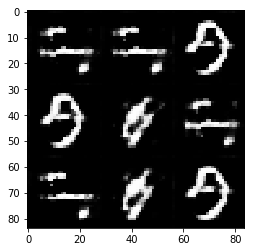

Step2210 Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.0228
Step2220 Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.9275
Step2230 Epoch 2/2... Discriminator Loss: 0.6077... Generator Loss: 1.7645
Step2240 Epoch 2/2... Discriminator Loss: 0.7105... Generator Loss: 1.2689
Step2250 Epoch 2/2... Discriminator Loss: 0.6276... Generator Loss: 1.8302
Step2260 Epoch 2/2... Discriminator Loss: 0.6238... Generator Loss: 1.9931
Step2270 Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 1.4470
Step2280 Epoch 2/2... Discriminator Loss: 0.6252... Generator Loss: 2.1433
Step2290 Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 2.0080
Step2300 Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.2932


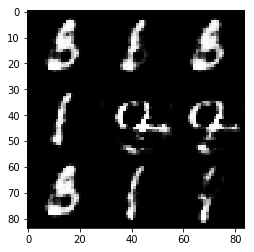

Step2310 Epoch 2/2... Discriminator Loss: 0.7573... Generator Loss: 1.4835
Step2320 Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.2300
Step2330 Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.4839
Step2340 Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 2.3183
Step2350 Epoch 2/2... Discriminator Loss: 0.6158... Generator Loss: 2.4703
Step2360 Epoch 2/2... Discriminator Loss: 0.8055... Generator Loss: 1.3582
Step2370 Epoch 2/2... Discriminator Loss: 0.7184... Generator Loss: 1.7715
Step2380 Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 3.3280
Step2390 Epoch 2/2... Discriminator Loss: 0.9932... Generator Loss: 0.8812
Step2400 Epoch 2/2... Discriminator Loss: 0.8836... Generator Loss: 1.0126


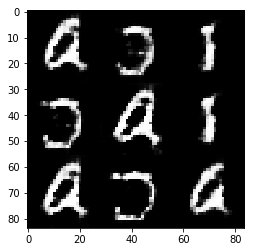

Step2410 Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 1.0003
Step2420 Epoch 2/2... Discriminator Loss: 0.6211... Generator Loss: 1.6880
Step2430 Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 1.7371
Step2440 Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 3.0961
Step2450 Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 0.8200
Step2460 Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 2.0435
Step2470 Epoch 2/2... Discriminator Loss: 0.5802... Generator Loss: 2.2860
Step2480 Epoch 2/2... Discriminator Loss: 0.7704... Generator Loss: 2.2639
Step2490 Epoch 2/2... Discriminator Loss: 0.8569... Generator Loss: 1.3121
Step2500 Epoch 2/2... Discriminator Loss: 0.5892... Generator Loss: 2.0567


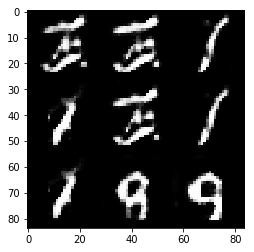

Step2510 Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.2521
Step2520 Epoch 2/2... Discriminator Loss: 0.8178... Generator Loss: 1.1084
Step2530 Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 2.6862
Step2540 Epoch 2/2... Discriminator Loss: 0.8294... Generator Loss: 1.1777
Step2550 Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 2.2871
Step2560 Epoch 2/2... Discriminator Loss: 0.6831... Generator Loss: 1.5105
Step2570 Epoch 2/2... Discriminator Loss: 0.6811... Generator Loss: 3.1385
Step2580 Epoch 2/2... Discriminator Loss: 0.5035... Generator Loss: 2.6494
Step2590 Epoch 2/2... Discriminator Loss: 0.5926... Generator Loss: 2.2860
Step2600 Epoch 2/2... Discriminator Loss: 0.7729... Generator Loss: 1.7076


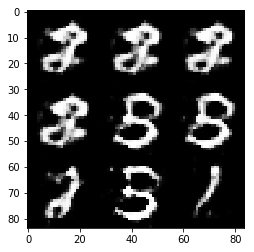

Step2610 Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 4.2070
Step2620 Epoch 2/2... Discriminator Loss: 0.6820... Generator Loss: 1.5698
Step2630 Epoch 2/2... Discriminator Loss: 0.6686... Generator Loss: 2.4316
Step2640 Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 2.8645
Step2650 Epoch 2/2... Discriminator Loss: 0.7839... Generator Loss: 1.4866
Step2660 Epoch 2/2... Discriminator Loss: 0.6163... Generator Loss: 1.8860
Step2670 Epoch 2/2... Discriminator Loss: 0.6309... Generator Loss: 2.3237
Step2680 Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.9224
Step2690 Epoch 2/2... Discriminator Loss: 0.6930... Generator Loss: 1.6561
Step2700 Epoch 2/2... Discriminator Loss: 0.7491... Generator Loss: 1.2693


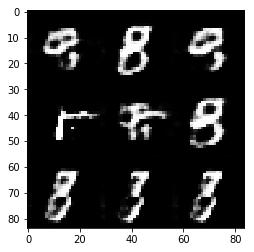

Step2710 Epoch 2/2... Discriminator Loss: 1.3635... Generator Loss: 0.4980
Step2720 Epoch 2/2... Discriminator Loss: 0.5996... Generator Loss: 1.8141
Step2730 Epoch 2/2... Discriminator Loss: 0.7294... Generator Loss: 1.5677
Step2740 Epoch 2/2... Discriminator Loss: 0.6210... Generator Loss: 2.7811
Step2750 Epoch 2/2... Discriminator Loss: 0.7641... Generator Loss: 3.0997
Step2760 Epoch 2/2... Discriminator Loss: 0.5697... Generator Loss: 2.4581
Step2770 Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 1.9064
Step2780 Epoch 2/2... Discriminator Loss: 0.8271... Generator Loss: 1.2067
Step2790 Epoch 2/2... Discriminator Loss: 0.5461... Generator Loss: 2.1655
Step2800 Epoch 2/2... Discriminator Loss: 0.7314... Generator Loss: 1.4660


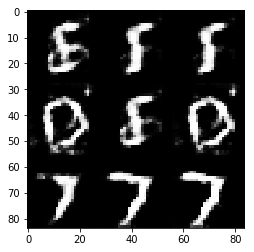

Step2810 Epoch 2/2... Discriminator Loss: 0.5502... Generator Loss: 2.7578
Step2820 Epoch 2/2... Discriminator Loss: 0.7773... Generator Loss: 2.8489
Step2830 Epoch 2/2... Discriminator Loss: 0.7487... Generator Loss: 1.5695
Step2840 Epoch 2/2... Discriminator Loss: 0.7549... Generator Loss: 1.6586
Step2850 Epoch 2/2... Discriminator Loss: 0.7357... Generator Loss: 1.6578
Step2860 Epoch 2/2... Discriminator Loss: 0.6146... Generator Loss: 2.2715
Step2870 Epoch 2/2... Discriminator Loss: 0.5856... Generator Loss: 1.9291
Step2880 Epoch 2/2... Discriminator Loss: 0.5201... Generator Loss: 2.4037
Step2890 Epoch 2/2... Discriminator Loss: 0.7682... Generator Loss: 2.3326
Step2900 Epoch 2/2... Discriminator Loss: 0.5991... Generator Loss: 2.0619


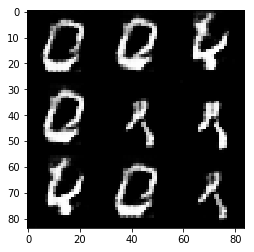

Step2910 Epoch 2/2... Discriminator Loss: 0.5407... Generator Loss: 2.7982
Step2920 Epoch 2/2... Discriminator Loss: 0.5096... Generator Loss: 2.2852
Step2930 Epoch 2/2... Discriminator Loss: 0.6837... Generator Loss: 1.4475
Step2940 Epoch 2/2... Discriminator Loss: 0.5739... Generator Loss: 2.7730
Step2950 Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 2.6538
Step2960 Epoch 2/2... Discriminator Loss: 0.5625... Generator Loss: 2.3034
Step2970 Epoch 2/2... Discriminator Loss: 0.7236... Generator Loss: 2.1481
Step2980 Epoch 2/2... Discriminator Loss: 0.5918... Generator Loss: 1.9444
Step2990 Epoch 2/2... Discriminator Loss: 0.5872... Generator Loss: 2.8796
Step3000 Epoch 2/2... Discriminator Loss: 0.5616... Generator Loss: 1.8994


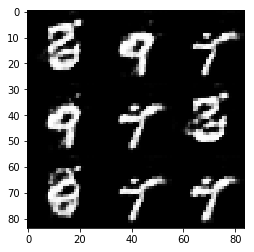

Step3010 Epoch 2/2... Discriminator Loss: 0.5438... Generator Loss: 2.3692
Step3020 Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.9182
Step3030 Epoch 2/2... Discriminator Loss: 0.4704... Generator Loss: 3.0089
Step3040 Epoch 2/2... Discriminator Loss: 0.6978... Generator Loss: 1.5299
Step3050 Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 2.5016
Step3060 Epoch 2/2... Discriminator Loss: 0.6736... Generator Loss: 1.5528
Step3070 Epoch 2/2... Discriminator Loss: 0.4851... Generator Loss: 2.9026
Step3080 Epoch 2/2... Discriminator Loss: 0.8607... Generator Loss: 2.3572
Step3090 Epoch 2/2... Discriminator Loss: 0.6984... Generator Loss: 2.2591
Step3100 Epoch 2/2... Discriminator Loss: 0.5277... Generator Loss: 2.6961


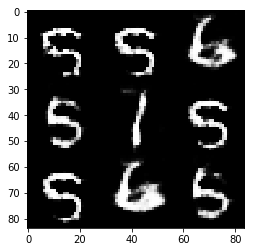

Step3110 Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 2.0202
Step3120 Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.4865
Step3130 Epoch 2/2... Discriminator Loss: 1.7102... Generator Loss: 5.5635
Step3140 Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.8967
Step3150 Epoch 2/2... Discriminator Loss: 0.5708... Generator Loss: 1.9138
Step3160 Epoch 2/2... Discriminator Loss: 0.8441... Generator Loss: 1.1755
Step3170 Epoch 2/2... Discriminator Loss: 0.8510... Generator Loss: 3.7251
Step3180 Epoch 2/2... Discriminator Loss: 0.6850... Generator Loss: 2.5116
Step3190 Epoch 2/2... Discriminator Loss: 0.7909... Generator Loss: 1.3540
Step3200 Epoch 2/2... Discriminator Loss: 0.6910... Generator Loss: 1.5905


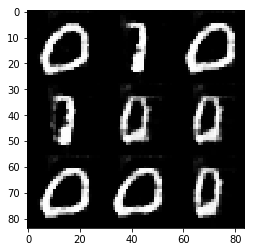

Step3210 Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 2.0550
Step3220 Epoch 2/2... Discriminator Loss: 0.5582... Generator Loss: 2.2983
Step3230 Epoch 2/2... Discriminator Loss: 0.8098... Generator Loss: 1.3422
Step3240 Epoch 2/2... Discriminator Loss: 0.5786... Generator Loss: 1.9439
Step3250 Epoch 2/2... Discriminator Loss: 0.6338... Generator Loss: 3.0442
Step3260 Epoch 2/2... Discriminator Loss: 0.5982... Generator Loss: 2.1699
Step3270 Epoch 2/2... Discriminator Loss: 0.5109... Generator Loss: 2.4446
Step3280 Epoch 2/2... Discriminator Loss: 0.8948... Generator Loss: 1.0217
Step3290 Epoch 2/2... Discriminator Loss: 0.5893... Generator Loss: 2.1249
Step3300 Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.6846


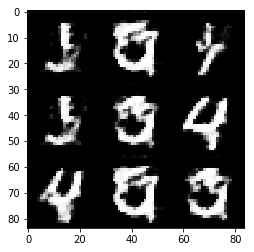

Step3310 Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 3.2055
Step3320 Epoch 2/2... Discriminator Loss: 0.6178... Generator Loss: 3.2219
Step3330 Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.7522
Step3340 Epoch 2/2... Discriminator Loss: 0.6706... Generator Loss: 1.6289
Step3350 Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 2.8569
Step3360 Epoch 2/2... Discriminator Loss: 0.5726... Generator Loss: 2.0880
Step3370 Epoch 2/2... Discriminator Loss: 0.6291... Generator Loss: 3.0581
Step3380 Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 3.6081
Step3390 Epoch 2/2... Discriminator Loss: 0.5511... Generator Loss: 2.6480
Step3400 Epoch 2/2... Discriminator Loss: 0.6179... Generator Loss: 2.7829


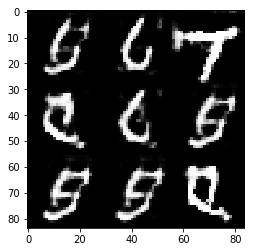

Step3410 Epoch 2/2... Discriminator Loss: 1.0482... Generator Loss: 0.7770
Step3420 Epoch 2/2... Discriminator Loss: 0.5979... Generator Loss: 2.3918
Step3430 Epoch 2/2... Discriminator Loss: 0.7601... Generator Loss: 1.6906
Step3440 Epoch 2/2... Discriminator Loss: 0.5166... Generator Loss: 2.5706
Step3450 Epoch 2/2... Discriminator Loss: 0.4701... Generator Loss: 2.8345
Step3460 Epoch 2/2... Discriminator Loss: 0.6031... Generator Loss: 2.0217
Step3470 Epoch 2/2... Discriminator Loss: 0.8062... Generator Loss: 1.6943
Step3480 Epoch 2/2... Discriminator Loss: 0.7015... Generator Loss: 1.5163
Step3490 Epoch 2/2... Discriminator Loss: 1.3658... Generator Loss: 0.5816
Step3500 Epoch 2/2... Discriminator Loss: 0.6508... Generator Loss: 1.6311


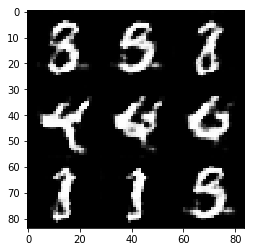

Step3510 Epoch 2/2... Discriminator Loss: 0.5534... Generator Loss: 2.4516
Step3520 Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 2.2608
Step3530 Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.9778
Step3540 Epoch 2/2... Discriminator Loss: 0.5099... Generator Loss: 2.4876
Step3550 Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 1.8344
Step3560 Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 1.2424
Step3570 Epoch 2/2... Discriminator Loss: 0.5284... Generator Loss: 2.0309
Step3580 Epoch 2/2... Discriminator Loss: 0.6648... Generator Loss: 1.8058
Step3590 Epoch 2/2... Discriminator Loss: 0.9685... Generator Loss: 0.9870
Step3600 Epoch 2/2... Discriminator Loss: 0.8475... Generator Loss: 1.1830


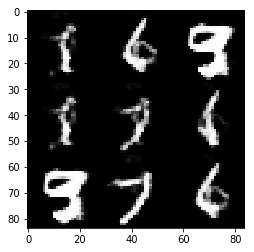

Step3610 Epoch 2/2... Discriminator Loss: 0.8612... Generator Loss: 1.0777
Step3620 Epoch 2/2... Discriminator Loss: 0.9018... Generator Loss: 0.9681
Step3630 Epoch 2/2... Discriminator Loss: 0.5908... Generator Loss: 2.4010
Step3640 Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 1.8743
Step3650 Epoch 2/2... Discriminator Loss: 0.5506... Generator Loss: 2.0515
Step3660 Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.8440
Step3670 Epoch 2/2... Discriminator Loss: 0.6619... Generator Loss: 1.6621
Step3680 Epoch 2/2... Discriminator Loss: 0.5631... Generator Loss: 1.9209
Step3690 Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 3.3464
Step3700 Epoch 2/2... Discriminator Loss: 0.4601... Generator Loss: 3.1744


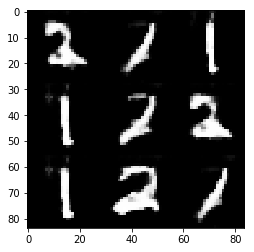

Step3710 Epoch 2/2... Discriminator Loss: 0.5337... Generator Loss: 2.4052
Step3720 Epoch 2/2... Discriminator Loss: 0.6337... Generator Loss: 1.5466
Step3730 Epoch 2/2... Discriminator Loss: 1.0646... Generator Loss: 0.9402
Step3740 Epoch 2/2... Discriminator Loss: 0.7395... Generator Loss: 2.0351
Step3750 Epoch 2/2... Discriminator Loss: 0.5787... Generator Loss: 2.1248


In [57]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Step10 Epoch 1/1... Discriminator Loss: 4.2575... Generator Loss: 0.0350
Step20 Epoch 1/1... Discriminator Loss: 1.7963... Generator Loss: 0.4629
Step30 Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.5985
Step40 Epoch 1/1... Discriminator Loss: 1.3037... Generator Loss: 0.8539
Step50 Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.1212
Step60 Epoch 1/1... Discriminator Loss: 1.7864... Generator Loss: 0.7276
Step70 Epoch 1/1... Discriminator Loss: 0.9148... Generator Loss: 1.3941
Step80 Epoch 1/1... Discriminator Loss: 0.7142... Generator Loss: 1.6009
Step90 Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.9481
Step100 Epoch 1/1... Discriminator Loss: 1.6765... Generator Loss: 0.8380


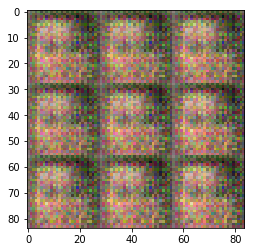

Step110 Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 1.3052
Step120 Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.5698
Step130 Epoch 1/1... Discriminator Loss: 0.7353... Generator Loss: 1.9860
Step140 Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 1.0630
Step150 Epoch 1/1... Discriminator Loss: 0.8271... Generator Loss: 1.3119
Step160 Epoch 1/1... Discriminator Loss: 0.5605... Generator Loss: 2.1968
Step170 Epoch 1/1... Discriminator Loss: 0.9413... Generator Loss: 1.3698
Step180 Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 1.4603
Step190 Epoch 1/1... Discriminator Loss: 0.8465... Generator Loss: 1.9553
Step200 Epoch 1/1... Discriminator Loss: 0.6972... Generator Loss: 1.6323


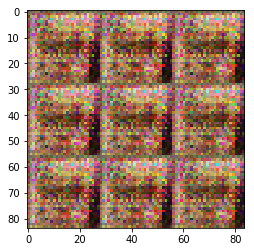

Step210 Epoch 1/1... Discriminator Loss: 0.5684... Generator Loss: 2.2028
Step220 Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 2.0225
Step230 Epoch 1/1... Discriminator Loss: 0.5915... Generator Loss: 1.9774
Step240 Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.9109
Step250 Epoch 1/1... Discriminator Loss: 0.6181... Generator Loss: 2.0138
Step260 Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 1.5645
Step270 Epoch 1/1... Discriminator Loss: 0.6477... Generator Loss: 2.2065
Step280 Epoch 1/1... Discriminator Loss: 0.7667... Generator Loss: 1.9917
Step290 Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 2.5344
Step300 Epoch 1/1... Discriminator Loss: 0.5419... Generator Loss: 2.1477


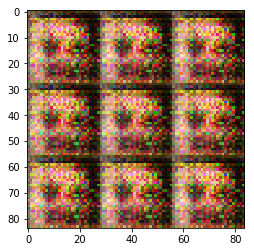

Step310 Epoch 1/1... Discriminator Loss: 0.4564... Generator Loss: 2.6713
Step320 Epoch 1/1... Discriminator Loss: 0.4316... Generator Loss: 2.9397
Step330 Epoch 1/1... Discriminator Loss: 0.6218... Generator Loss: 2.0520
Step340 Epoch 1/1... Discriminator Loss: 0.4986... Generator Loss: 2.3748
Step350 Epoch 1/1... Discriminator Loss: 0.6763... Generator Loss: 2.2765
Step360 Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 2.2790
Step370 Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 2.2789
Step380 Epoch 1/1... Discriminator Loss: 0.5534... Generator Loss: 2.1432
Step390 Epoch 1/1... Discriminator Loss: 0.4820... Generator Loss: 2.7368
Step400 Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 2.1652


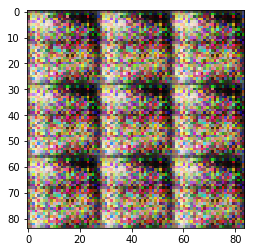

Step410 Epoch 1/1... Discriminator Loss: 0.5697... Generator Loss: 2.2505
Step420 Epoch 1/1... Discriminator Loss: 0.4705... Generator Loss: 2.5718
Step430 Epoch 1/1... Discriminator Loss: 0.5659... Generator Loss: 2.5529
Step440 Epoch 1/1... Discriminator Loss: 0.4385... Generator Loss: 2.7347
Step450 Epoch 1/1... Discriminator Loss: 0.7860... Generator Loss: 1.3071
Step460 Epoch 1/1... Discriminator Loss: 0.4700... Generator Loss: 2.8614
Step470 Epoch 1/1... Discriminator Loss: 0.4983... Generator Loss: 2.3058
Step480 Epoch 1/1... Discriminator Loss: 0.3951... Generator Loss: 3.1321
Step490 Epoch 1/1... Discriminator Loss: 0.4121... Generator Loss: 3.2974
Step500 Epoch 1/1... Discriminator Loss: 0.5157... Generator Loss: 1.9515


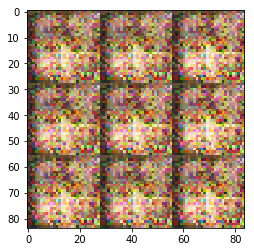

Step510 Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.2608
Step520 Epoch 1/1... Discriminator Loss: 1.6498... Generator Loss: 0.6133
Step530 Epoch 1/1... Discriminator Loss: 0.7946... Generator Loss: 1.4449
Step540 Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.5006
Step550 Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.0922
Step560 Epoch 1/1... Discriminator Loss: 0.8941... Generator Loss: 1.2997
Step570 Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 0.9667
Step580 Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.5799
Step590 Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7267
Step600 Epoch 1/1... Discriminator Loss: 0.8793... Generator Loss: 1.2094


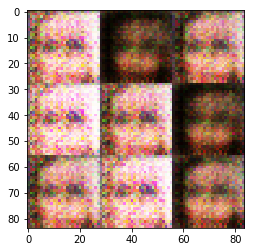

Step610 Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.1563
Step620 Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8737
Step630 Epoch 1/1... Discriminator Loss: 1.0410... Generator Loss: 0.9945
Step640 Epoch 1/1... Discriminator Loss: 0.6987... Generator Loss: 1.7278
Step650 Epoch 1/1... Discriminator Loss: 1.0484... Generator Loss: 1.1616
Step660 Epoch 1/1... Discriminator Loss: 0.6863... Generator Loss: 1.5855
Step670 Epoch 1/1... Discriminator Loss: 1.1873... Generator Loss: 0.8140
Step680 Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.8715
Step690 Epoch 1/1... Discriminator Loss: 1.0252... Generator Loss: 1.1764
Step700 Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 1.0549


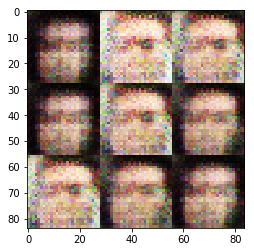

Step710 Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 0.8041
Step720 Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 1.0626
Step730 Epoch 1/1... Discriminator Loss: 0.7620... Generator Loss: 1.6295
Step740 Epoch 1/1... Discriminator Loss: 0.9338... Generator Loss: 1.3416
Step750 Epoch 1/1... Discriminator Loss: 0.8517... Generator Loss: 2.0219
Step760 Epoch 1/1... Discriminator Loss: 0.8811... Generator Loss: 1.8388
Step770 Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.5657
Step780 Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.5606
Step790 Epoch 1/1... Discriminator Loss: 1.7647... Generator Loss: 0.5629
Step800 Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 1.0766


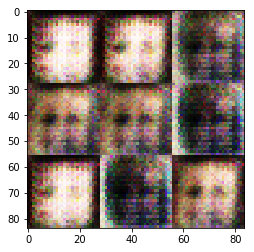

Step810 Epoch 1/1... Discriminator Loss: 0.8934... Generator Loss: 1.3330
Step820 Epoch 1/1... Discriminator Loss: 0.8765... Generator Loss: 1.7227
Step830 Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.2783
Step840 Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 1.1748
Step850 Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 0.8807
Step860 Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 1.0739
Step870 Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 1.2329
Step880 Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.9764
Step890 Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.0997
Step900 Epoch 1/1... Discriminator Loss: 1.0075... Generator Loss: 1.0353


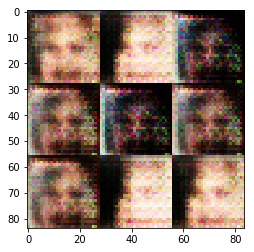

Step910 Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 1.1650
Step920 Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 1.0870
Step930 Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.5629
Step940 Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 1.2562
Step950 Epoch 1/1... Discriminator Loss: 0.9436... Generator Loss: 1.2794
Step960 Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.9321
Step970 Epoch 1/1... Discriminator Loss: 0.8279... Generator Loss: 1.3834
Step980 Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 1.2292
Step990 Epoch 1/1... Discriminator Loss: 1.1824... Generator Loss: 0.9601
Step1000 Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.9014


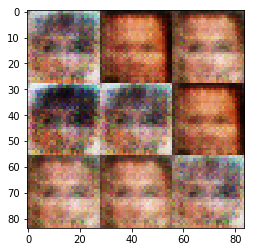

Step1010 Epoch 1/1... Discriminator Loss: 1.0976... Generator Loss: 1.3147
Step1020 Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.8315
Step1030 Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.2708
Step1040 Epoch 1/1... Discriminator Loss: 1.1284... Generator Loss: 1.2552
Step1050 Epoch 1/1... Discriminator Loss: 1.2332... Generator Loss: 0.9081
Step1060 Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 1.0352
Step1070 Epoch 1/1... Discriminator Loss: 0.9654... Generator Loss: 1.3897
Step1080 Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.6669
Step1090 Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.0660
Step1100 Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 1.2932


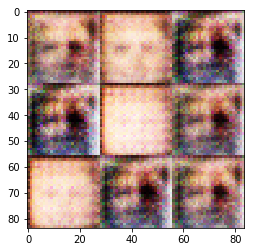

Step1110 Epoch 1/1... Discriminator Loss: 1.2005... Generator Loss: 1.0650
Step1120 Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.3343
Step1130 Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 1.2402
Step1140 Epoch 1/1... Discriminator Loss: 1.1598... Generator Loss: 1.6601
Step1150 Epoch 1/1... Discriminator Loss: 1.0172... Generator Loss: 1.2789
Step1160 Epoch 1/1... Discriminator Loss: 1.4806... Generator Loss: 0.7710
Step1170 Epoch 1/1... Discriminator Loss: 1.5692... Generator Loss: 0.7941
Step1180 Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.3146
Step1190 Epoch 1/1... Discriminator Loss: 1.0100... Generator Loss: 1.4248
Step1200 Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6512


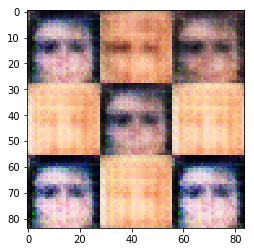

Step1210 Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.9891
Step1220 Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 1.1592
Step1230 Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.6810
Step1240 Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 1.8507
Step1250 Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.7974
Step1260 Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.8956
Step1270 Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.6916
Step1280 Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8452
Step1290 Epoch 1/1... Discriminator Loss: 1.6300... Generator Loss: 0.9774
Step1300 Epoch 1/1... Discriminator Loss: 1.5484... Generator Loss: 0.7073


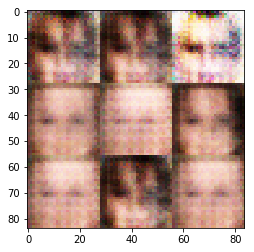

Step1310 Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 1.0027
Step1320 Epoch 1/1... Discriminator Loss: 1.1435... Generator Loss: 0.8685
Step1330 Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 1.2940
Step1340 Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.9109
Step1350 Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9464
Step1360 Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8626
Step1370 Epoch 1/1... Discriminator Loss: 1.3026... Generator Loss: 0.8406
Step1380 Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.1974
Step1390 Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.2306
Step1400 Epoch 1/1... Discriminator Loss: 0.8570... Generator Loss: 1.4069


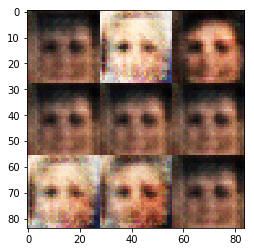

Step1410 Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.7531
Step1420 Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.8730
Step1430 Epoch 1/1... Discriminator Loss: 1.0930... Generator Loss: 0.9042
Step1440 Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.2853
Step1450 Epoch 1/1... Discriminator Loss: 1.0184... Generator Loss: 1.0816
Step1460 Epoch 1/1... Discriminator Loss: 0.8415... Generator Loss: 1.4465
Step1470 Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 1.2593
Step1480 Epoch 1/1... Discriminator Loss: 0.9804... Generator Loss: 1.0708
Step1490 Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 0.8243
Step1500 Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.2560


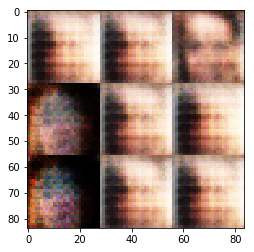

Step1510 Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.5073
Step1520 Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 1.1692
Step1530 Epoch 1/1... Discriminator Loss: 0.9945... Generator Loss: 1.0991
Step1540 Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 2.1820
Step1550 Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.3612
Step1560 Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.9591
Step1570 Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.1984
Step1580 Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.2870
Step1590 Epoch 1/1... Discriminator Loss: 1.0751... Generator Loss: 1.1753
Step1600 Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.1832


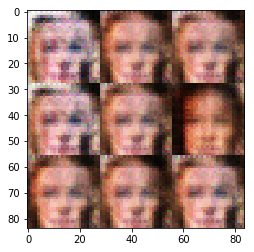

Step1610 Epoch 1/1... Discriminator Loss: 0.9987... Generator Loss: 1.1944
Step1620 Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7479
Step1630 Epoch 1/1... Discriminator Loss: 0.7942... Generator Loss: 1.5957
Step1640 Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.3569
Step1650 Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0780
Step1660 Epoch 1/1... Discriminator Loss: 0.8667... Generator Loss: 1.1345
Step1670 Epoch 1/1... Discriminator Loss: 0.7039... Generator Loss: 2.1051
Step1680 Epoch 1/1... Discriminator Loss: 0.9509... Generator Loss: 1.2685
Step1690 Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.1894
Step1700 Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.9122


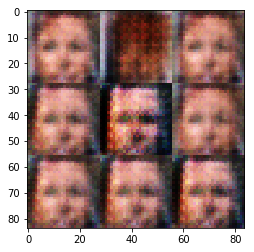

Step1710 Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.3334
Step1720 Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.2563
Step1730 Epoch 1/1... Discriminator Loss: 0.8109... Generator Loss: 1.4395
Step1740 Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.9847
Step1750 Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.5828
Step1760 Epoch 1/1... Discriminator Loss: 1.0382... Generator Loss: 1.1894
Step1770 Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 0.7825
Step1780 Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.3999
Step1790 Epoch 1/1... Discriminator Loss: 1.0083... Generator Loss: 1.4052
Step1800 Epoch 1/1... Discriminator Loss: 0.7033... Generator Loss: 1.3721


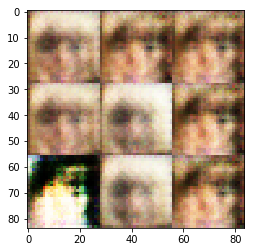

Step1810 Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1700
Step1820 Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.3804
Step1830 Epoch 1/1... Discriminator Loss: 0.6261... Generator Loss: 1.8994
Step1840 Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 1.2217
Step1850 Epoch 1/1... Discriminator Loss: 1.0852... Generator Loss: 1.1619
Step1860 Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 1.3788
Step1870 Epoch 1/1... Discriminator Loss: 0.9596... Generator Loss: 1.2915
Step1880 Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.9810
Step1890 Epoch 1/1... Discriminator Loss: 0.9514... Generator Loss: 1.2183
Step1900 Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.6895


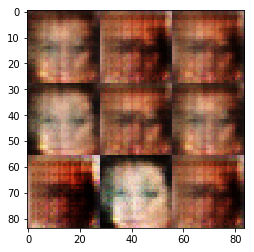

Step1910 Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.7745
Step1920 Epoch 1/1... Discriminator Loss: 0.6933... Generator Loss: 2.1048
Step1930 Epoch 1/1... Discriminator Loss: 0.7283... Generator Loss: 1.7795
Step1940 Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.3734
Step1950 Epoch 1/1... Discriminator Loss: 0.9358... Generator Loss: 1.1902
Step1960 Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.3006
Step1970 Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1331
Step1980 Epoch 1/1... Discriminator Loss: 0.8823... Generator Loss: 1.2664
Step1990 Epoch 1/1... Discriminator Loss: 0.9817... Generator Loss: 1.1902
Step2000 Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 1.3828


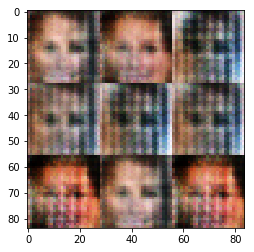

Step2010 Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.8527
Step2020 Epoch 1/1... Discriminator Loss: 1.1069... Generator Loss: 1.1882
Step2030 Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.8235
Step2040 Epoch 1/1... Discriminator Loss: 0.7691... Generator Loss: 1.6731
Step2050 Epoch 1/1... Discriminator Loss: 0.7043... Generator Loss: 1.9317
Step2060 Epoch 1/1... Discriminator Loss: 0.7010... Generator Loss: 1.6416
Step2070 Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 1.1721
Step2080 Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 2.0369
Step2090 Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 0.7411
Step2100 Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 1.4186


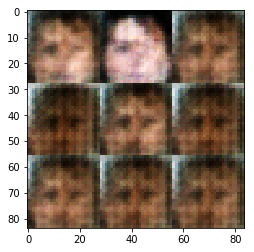

Step2110 Epoch 1/1... Discriminator Loss: 0.6246... Generator Loss: 1.8323
Step2120 Epoch 1/1... Discriminator Loss: 0.8333... Generator Loss: 1.6143
Step2130 Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.7744
Step2140 Epoch 1/1... Discriminator Loss: 0.7727... Generator Loss: 1.9006
Step2150 Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 1.2505
Step2160 Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.3362
Step2170 Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.8711
Step2180 Epoch 1/1... Discriminator Loss: 1.6858... Generator Loss: 0.4479
Step2190 Epoch 1/1... Discriminator Loss: 0.7736... Generator Loss: 1.6254
Step2200 Epoch 1/1... Discriminator Loss: 0.7601... Generator Loss: 1.5966


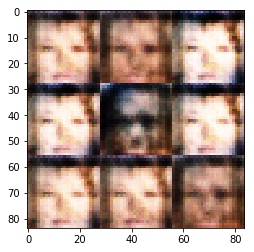

Step2210 Epoch 1/1... Discriminator Loss: 0.9450... Generator Loss: 1.2784
Step2220 Epoch 1/1... Discriminator Loss: 1.1717... Generator Loss: 1.1210
Step2230 Epoch 1/1... Discriminator Loss: 0.7687... Generator Loss: 1.7300
Step2240 Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.7687
Step2250 Epoch 1/1... Discriminator Loss: 0.9494... Generator Loss: 1.0366
Step2260 Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.9251
Step2270 Epoch 1/1... Discriminator Loss: 0.7844... Generator Loss: 1.3387
Step2280 Epoch 1/1... Discriminator Loss: 0.7085... Generator Loss: 1.5880
Step2290 Epoch 1/1... Discriminator Loss: 0.6925... Generator Loss: 1.6810
Step2300 Epoch 1/1... Discriminator Loss: 0.8938... Generator Loss: 1.2139


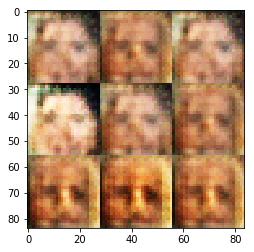

Step2310 Epoch 1/1... Discriminator Loss: 0.8176... Generator Loss: 1.4130
Step2320 Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.4690
Step2330 Epoch 1/1... Discriminator Loss: 1.0312... Generator Loss: 1.0428
Step2340 Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 1.4236
Step2350 Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.3866
Step2360 Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 2.0752
Step2370 Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.2630
Step2380 Epoch 1/1... Discriminator Loss: 0.8101... Generator Loss: 1.4332
Step2390 Epoch 1/1... Discriminator Loss: 0.9314... Generator Loss: 1.3496
Step2400 Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 2.2326


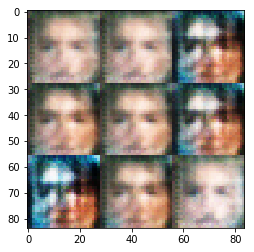

Step2410 Epoch 1/1... Discriminator Loss: 0.7048... Generator Loss: 1.7052
Step2420 Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.2698
Step2430 Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.8950
Step2440 Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.4641
Step2450 Epoch 1/1... Discriminator Loss: 0.8119... Generator Loss: 1.5016
Step2460 Epoch 1/1... Discriminator Loss: 0.6437... Generator Loss: 2.0320
Step2470 Epoch 1/1... Discriminator Loss: 0.7189... Generator Loss: 1.9470
Step2480 Epoch 1/1... Discriminator Loss: 0.8315... Generator Loss: 1.2702
Step2490 Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.0536
Step2500 Epoch 1/1... Discriminator Loss: 0.9023... Generator Loss: 1.2462


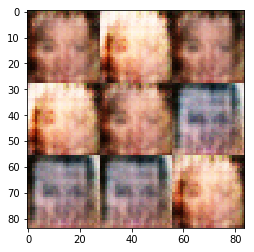

Step2510 Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.7759
Step2520 Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.8453
Step2530 Epoch 1/1... Discriminator Loss: 1.0056... Generator Loss: 1.9423
Step2540 Epoch 1/1... Discriminator Loss: 0.9640... Generator Loss: 1.4064
Step2550 Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.1812
Step2560 Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 1.1986
Step2570 Epoch 1/1... Discriminator Loss: 1.0261... Generator Loss: 0.9516
Step2580 Epoch 1/1... Discriminator Loss: 0.7714... Generator Loss: 1.9599
Step2590 Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.9301
Step2600 Epoch 1/1... Discriminator Loss: 0.9214... Generator Loss: 1.1875


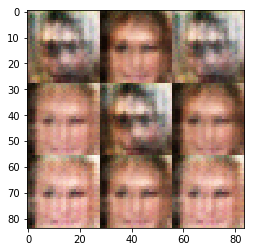

Step2610 Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.6736
Step2620 Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.1745
Step2630 Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.5595
Step2640 Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7064
Step2650 Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.7741
Step2660 Epoch 1/1... Discriminator Loss: 0.6639... Generator Loss: 1.7059
Step2670 Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.6409
Step2680 Epoch 1/1... Discriminator Loss: 0.8243... Generator Loss: 1.3802
Step2690 Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.5637
Step2700 Epoch 1/1... Discriminator Loss: 0.6425... Generator Loss: 1.9415


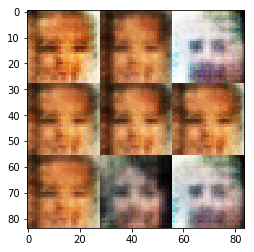

Step2710 Epoch 1/1... Discriminator Loss: 1.0437... Generator Loss: 1.1456
Step2720 Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9788
Step2730 Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.1221
Step2740 Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8740
Step2750 Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.3330
Step2760 Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.1592
Step2770 Epoch 1/1... Discriminator Loss: 0.8126... Generator Loss: 1.4352
Step2780 Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6014
Step2790 Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.6921
Step2800 Epoch 1/1... Discriminator Loss: 0.8067... Generator Loss: 1.2933


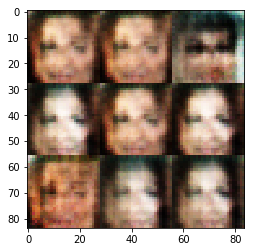

Step2810 Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 1.8502
Step2820 Epoch 1/1... Discriminator Loss: 1.0985... Generator Loss: 1.0699
Step2830 Epoch 1/1... Discriminator Loss: 0.9871... Generator Loss: 1.3326
Step2840 Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.6413
Step2850 Epoch 1/1... Discriminator Loss: 0.9858... Generator Loss: 1.2369
Step2860 Epoch 1/1... Discriminator Loss: 1.2628... Generator Loss: 1.0545
Step2870 Epoch 1/1... Discriminator Loss: 0.6971... Generator Loss: 1.6993
Step2880 Epoch 1/1... Discriminator Loss: 1.1133... Generator Loss: 0.9534
Step2890 Epoch 1/1... Discriminator Loss: 0.6936... Generator Loss: 1.6312
Step2900 Epoch 1/1... Discriminator Loss: 1.0393... Generator Loss: 1.1189


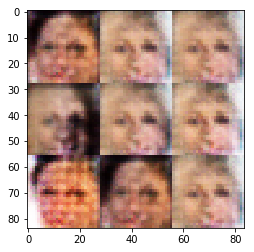

Step2910 Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.1160
Step2920 Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.2462
Step2930 Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 1.4259
Step2940 Epoch 1/1... Discriminator Loss: 0.9755... Generator Loss: 1.3604
Step2950 Epoch 1/1... Discriminator Loss: 1.0767... Generator Loss: 1.0307
Step2960 Epoch 1/1... Discriminator Loss: 1.2254... Generator Loss: 0.7153
Step2970 Epoch 1/1... Discriminator Loss: 0.9075... Generator Loss: 1.7298
Step2980 Epoch 1/1... Discriminator Loss: 0.6848... Generator Loss: 1.5857
Step2990 Epoch 1/1... Discriminator Loss: 0.6796... Generator Loss: 1.7434
Step3000 Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.9749


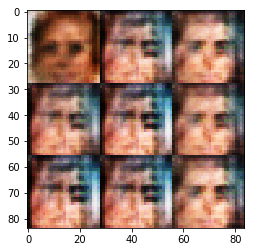

Step3010 Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 1.0537
Step3020 Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 1.2845
Step3030 Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.3595
Step3040 Epoch 1/1... Discriminator Loss: 0.9397... Generator Loss: 1.5027
Step3050 Epoch 1/1... Discriminator Loss: 1.1871... Generator Loss: 0.7687
Step3060 Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 1.0333
Step3070 Epoch 1/1... Discriminator Loss: 0.6298... Generator Loss: 1.8290
Step3080 Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.4444
Step3090 Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.7957
Step3100 Epoch 1/1... Discriminator Loss: 0.7478... Generator Loss: 2.0531


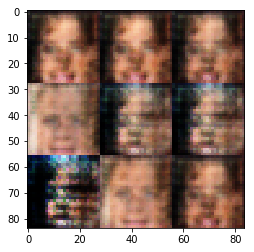

Step3110 Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.3257
Step3120 Epoch 1/1... Discriminator Loss: 0.9421... Generator Loss: 1.5055
Step3130 Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.2939
Step3140 Epoch 1/1... Discriminator Loss: 1.0301... Generator Loss: 1.0666
Step3150 Epoch 1/1... Discriminator Loss: 0.8011... Generator Loss: 1.6618
Step3160 Epoch 1/1... Discriminator Loss: 0.9232... Generator Loss: 1.1983
Step3170 Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.3954
Step3180 Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.0688
Step3190 Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.9446
Step3200 Epoch 1/1... Discriminator Loss: 0.8999... Generator Loss: 1.2771


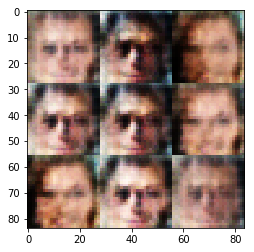

Step3210 Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 0.9726
Step3220 Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 1.1388
Step3230 Epoch 1/1... Discriminator Loss: 0.8049... Generator Loss: 1.2997
Step3240 Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.4546
Step3250 Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 1.6430
Step3260 Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.3042
Step3270 Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.4860
Step3280 Epoch 1/1... Discriminator Loss: 0.8624... Generator Loss: 1.3651
Step3290 Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.4985
Step3300 Epoch 1/1... Discriminator Loss: 0.8795... Generator Loss: 1.2371


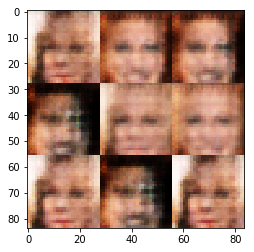

Step3310 Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.6827
Step3320 Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.4765
Step3330 Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 1.2201
Step3340 Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.2282
Step3350 Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.0846
Step3360 Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.8533
Step3370 Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.6311
Step3380 Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.8840
Step3390 Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.9061
Step3400 Epoch 1/1... Discriminator Loss: 0.8639... Generator Loss: 1.5781


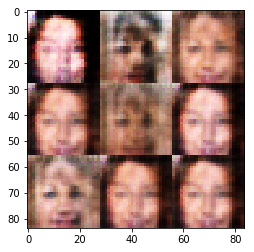

Step3410 Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.5775
Step3420 Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.5989
Step3430 Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 2.5155
Step3440 Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.0314
Step3450 Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.1632
Step3460 Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 1.0284
Step3470 Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.8877
Step3480 Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.2086
Step3490 Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.6876
Step3500 Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.9563


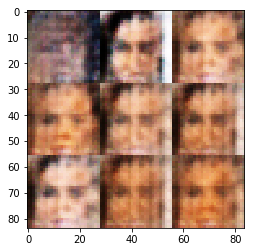

Step3510 Epoch 1/1... Discriminator Loss: 0.8447... Generator Loss: 1.4883
Step3520 Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.1323
Step3530 Epoch 1/1... Discriminator Loss: 0.9170... Generator Loss: 1.2821
Step3540 Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 1.0782
Step3550 Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.3175
Step3560 Epoch 1/1... Discriminator Loss: 1.1009... Generator Loss: 0.9060
Step3570 Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.2106
Step3580 Epoch 1/1... Discriminator Loss: 0.8340... Generator Loss: 1.3101
Step3590 Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.7487
Step3600 Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.2653


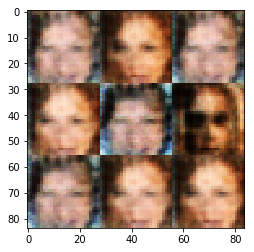

Step3610 Epoch 1/1... Discriminator Loss: 0.8753... Generator Loss: 1.5364
Step3620 Epoch 1/1... Discriminator Loss: 0.9978... Generator Loss: 1.5138
Step3630 Epoch 1/1... Discriminator Loss: 0.9267... Generator Loss: 1.3671
Step3640 Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8562
Step3650 Epoch 1/1... Discriminator Loss: 0.7584... Generator Loss: 1.9176
Step3660 Epoch 1/1... Discriminator Loss: 0.7030... Generator Loss: 1.9659
Step3670 Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.3555
Step3680 Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.5351
Step3690 Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.6496
Step3700 Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 1.1611


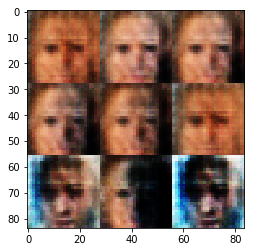

Step3710 Epoch 1/1... Discriminator Loss: 1.0616... Generator Loss: 1.2913
Step3720 Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.4029
Step3730 Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.7365
Step3740 Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 1.0288
Step3750 Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.1554
Step3760 Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.3658
Step3770 Epoch 1/1... Discriminator Loss: 0.6230... Generator Loss: 1.6773
Step3780 Epoch 1/1... Discriminator Loss: 0.7800... Generator Loss: 1.4466
Step3790 Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.6541
Step3800 Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.4031


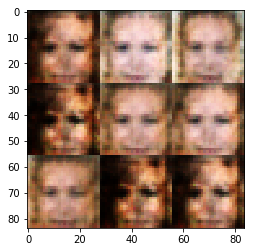

Step3810 Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.3103
Step3820 Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.8656
Step3830 Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 1.1647
Step3840 Epoch 1/1... Discriminator Loss: 0.8211... Generator Loss: 1.3478
Step3850 Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.3062
Step3860 Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.3952
Step3870 Epoch 1/1... Discriminator Loss: 1.0574... Generator Loss: 1.3047
Step3880 Epoch 1/1... Discriminator Loss: 0.6582... Generator Loss: 2.0544
Step3890 Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.5279
Step3900 Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.1051


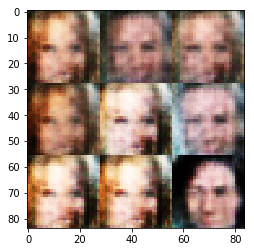

Step3910 Epoch 1/1... Discriminator Loss: 0.7526... Generator Loss: 2.0211
Step3920 Epoch 1/1... Discriminator Loss: 1.0260... Generator Loss: 1.0169
Step3930 Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6405
Step3940 Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 1.6201
Step3950 Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.5530
Step3960 Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.2347
Step3970 Epoch 1/1... Discriminator Loss: 1.0097... Generator Loss: 1.1119
Step3980 Epoch 1/1... Discriminator Loss: 0.7871... Generator Loss: 1.3436
Step3990 Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7663
Step4000 Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.6016


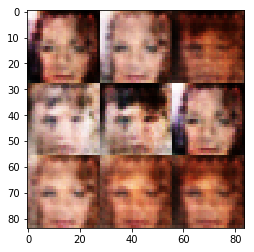

Step4010 Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.1228
Step4020 Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.5951
Step4030 Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 1.2511
Step4040 Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.4477
Step4050 Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.2887
Step4060 Epoch 1/1... Discriminator Loss: 0.8537... Generator Loss: 1.4702
Step4070 Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.3241
Step4080 Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.3623
Step4090 Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.8696
Step4100 Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.6463


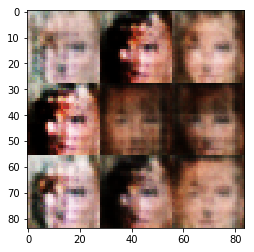

Step4110 Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.2754
Step4120 Epoch 1/1... Discriminator Loss: 1.4176... Generator Loss: 1.8548
Step4130 Epoch 1/1... Discriminator Loss: 1.1411... Generator Loss: 1.1021
Step4140 Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 0.8634
Step4150 Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 0.7943
Step4160 Epoch 1/1... Discriminator Loss: 1.1389... Generator Loss: 1.0998
Step4170 Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.8141
Step4180 Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 1.3533
Step4190 Epoch 1/1... Discriminator Loss: 0.9284... Generator Loss: 1.4567
Step4200 Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 1.1830


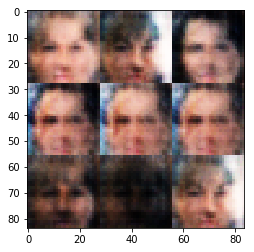

Step4210 Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.3059
Step4220 Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.5599
Step4230 Epoch 1/1... Discriminator Loss: 1.1653... Generator Loss: 1.0568
Step4240 Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.9832
Step4250 Epoch 1/1... Discriminator Loss: 1.5907... Generator Loss: 0.6064
Step4260 Epoch 1/1... Discriminator Loss: 1.1429... Generator Loss: 1.0454
Step4270 Epoch 1/1... Discriminator Loss: 1.0904... Generator Loss: 1.0801
Step4280 Epoch 1/1... Discriminator Loss: 0.9347... Generator Loss: 1.0507
Step4290 Epoch 1/1... Discriminator Loss: 1.0364... Generator Loss: 0.9393
Step4300 Epoch 1/1... Discriminator Loss: 0.9741... Generator Loss: 1.3767


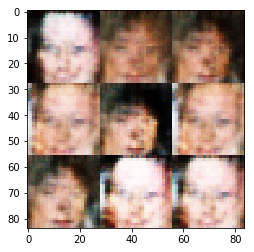

Step4310 Epoch 1/1... Discriminator Loss: 0.9020... Generator Loss: 1.1543
Step4320 Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 1.2814
Step4330 Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.6691
Step4340 Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.9721
Step4350 Epoch 1/1... Discriminator Loss: 1.0594... Generator Loss: 1.2246
Step4360 Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 1.1160
Step4370 Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 1.0292
Step4380 Epoch 1/1... Discriminator Loss: 0.9438... Generator Loss: 1.1101
Step4390 Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 0.9959
Step4400 Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.0151


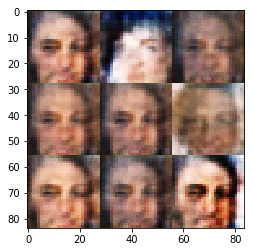

Step4410 Epoch 1/1... Discriminator Loss: 0.9511... Generator Loss: 1.3497
Step4420 Epoch 1/1... Discriminator Loss: 0.8290... Generator Loss: 1.3441
Step4430 Epoch 1/1... Discriminator Loss: 0.9294... Generator Loss: 1.3692
Step4440 Epoch 1/1... Discriminator Loss: 0.9107... Generator Loss: 1.1350
Step4450 Epoch 1/1... Discriminator Loss: 0.9038... Generator Loss: 1.1327
Step4460 Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 1.4315
Step4470 Epoch 1/1... Discriminator Loss: 0.9520... Generator Loss: 1.1765
Step4480 Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 1.3543
Step4490 Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 0.7619
Step4500 Epoch 1/1... Discriminator Loss: 1.0724... Generator Loss: 1.1197


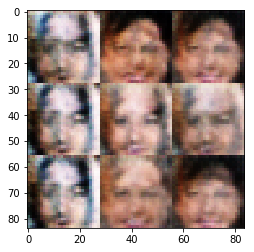

Step4510 Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 1.4354
Step4520 Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.7484
Step4530 Epoch 1/1... Discriminator Loss: 0.8134... Generator Loss: 1.5638
Step4540 Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8804
Step4550 Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.9642
Step4560 Epoch 1/1... Discriminator Loss: 0.7518... Generator Loss: 1.5816
Step4570 Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.0508
Step4580 Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 1.3775
Step4590 Epoch 1/1... Discriminator Loss: 0.7029... Generator Loss: 1.5465
Step4600 Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 1.2176


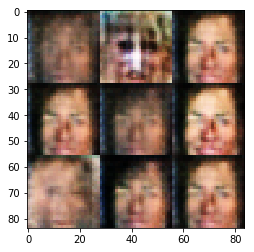

Step4610 Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 1.3084
Step4620 Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 1.4180
Step4630 Epoch 1/1... Discriminator Loss: 0.9493... Generator Loss: 1.5569
Step4640 Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.3103
Step4650 Epoch 1/1... Discriminator Loss: 0.7261... Generator Loss: 1.5529
Step4660 Epoch 1/1... Discriminator Loss: 0.8262... Generator Loss: 1.2116
Step4670 Epoch 1/1... Discriminator Loss: 0.8369... Generator Loss: 1.3562
Step4680 Epoch 1/1... Discriminator Loss: 0.9044... Generator Loss: 1.3711
Step4690 Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.2008
Step4700 Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.9612


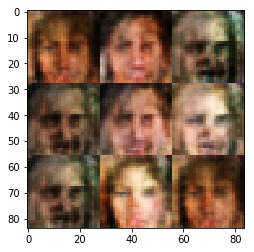

Step4710 Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.9022
Step4720 Epoch 1/1... Discriminator Loss: 1.8040... Generator Loss: 0.4280
Step4730 Epoch 1/1... Discriminator Loss: 0.9061... Generator Loss: 1.4388
Step4740 Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.1095
Step4750 Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 1.1855
Step4760 Epoch 1/1... Discriminator Loss: 0.9034... Generator Loss: 1.2516
Step4770 Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 1.0562
Step4780 Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.9816
Step4790 Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.2757
Step4800 Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.0804


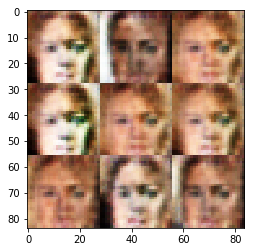

Step4810 Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.9520
Step4820 Epoch 1/1... Discriminator Loss: 0.8037... Generator Loss: 1.4368
Step4830 Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.4614
Step4840 Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.2981
Step4850 Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.6788
Step4860 Epoch 1/1... Discriminator Loss: 0.8682... Generator Loss: 1.3697
Step4870 Epoch 1/1... Discriminator Loss: 0.8506... Generator Loss: 1.5773
Step4880 Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.3927
Step4890 Epoch 1/1... Discriminator Loss: 0.9105... Generator Loss: 1.3771
Step4900 Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.4374


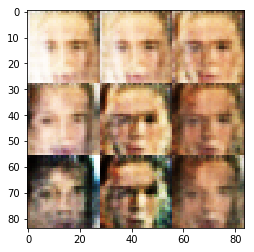

Step4910 Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.1174
Step4920 Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.1160
Step4930 Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.9488
Step4940 Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0081
Step4950 Epoch 1/1... Discriminator Loss: 0.8709... Generator Loss: 1.2852
Step4960 Epoch 1/1... Discriminator Loss: 1.1331... Generator Loss: 0.8359
Step4970 Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.8252
Step4980 Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.1402
Step4990 Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8736
Step5000 Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 1.0105


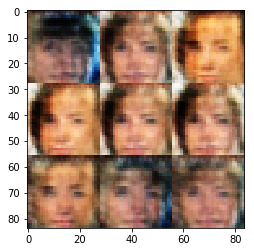

Step5010 Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9199
Step5020 Epoch 1/1... Discriminator Loss: 1.0316... Generator Loss: 1.0633
Step5030 Epoch 1/1... Discriminator Loss: 0.8301... Generator Loss: 1.5707
Step5040 Epoch 1/1... Discriminator Loss: 0.9151... Generator Loss: 1.4893
Step5050 Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.8114
Step5060 Epoch 1/1... Discriminator Loss: 0.8435... Generator Loss: 1.6551
Step5070 Epoch 1/1... Discriminator Loss: 0.8423... Generator Loss: 1.6576
Step5080 Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.6741
Step5090 Epoch 1/1... Discriminator Loss: 0.9331... Generator Loss: 1.5329
Step5100 Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 1.1225


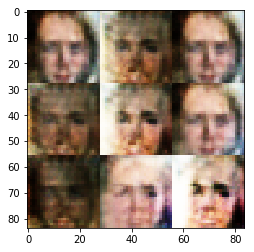

Step5110 Epoch 1/1... Discriminator Loss: 1.5864... Generator Loss: 0.6476
Step5120 Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.1088
Step5130 Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 0.8424
Step5140 Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 1.1894
Step5150 Epoch 1/1... Discriminator Loss: 1.8045... Generator Loss: 0.9064
Step5160 Epoch 1/1... Discriminator Loss: 0.9055... Generator Loss: 1.5994
Step5170 Epoch 1/1... Discriminator Loss: 1.0387... Generator Loss: 0.9399
Step5180 Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.4468
Step5190 Epoch 1/1... Discriminator Loss: 0.9496... Generator Loss: 1.1581
Step5200 Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 1.3196


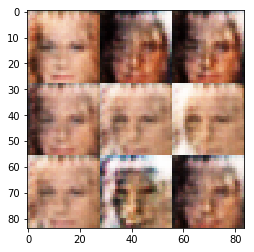

Step5210 Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.8867
Step5220 Epoch 1/1... Discriminator Loss: 0.8829... Generator Loss: 1.5472
Step5230 Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.1095
Step5240 Epoch 1/1... Discriminator Loss: 0.9800... Generator Loss: 1.0134
Step5250 Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 1.4019
Step5260 Epoch 1/1... Discriminator Loss: 0.7765... Generator Loss: 1.3248
Step5270 Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 1.1400
Step5280 Epoch 1/1... Discriminator Loss: 0.7920... Generator Loss: 1.4827
Step5290 Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.9035
Step5300 Epoch 1/1... Discriminator Loss: 1.0780... Generator Loss: 1.0729


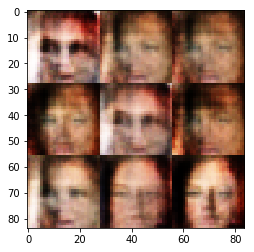

Step5310 Epoch 1/1... Discriminator Loss: 0.5845... Generator Loss: 2.2731
Step5320 Epoch 1/1... Discriminator Loss: 0.8916... Generator Loss: 1.3102
Step5330 Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 0.9039
Step5340 Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.5001
Step5350 Epoch 1/1... Discriminator Loss: 0.9473... Generator Loss: 1.1006
Step5360 Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.1302
Step5370 Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.3274
Step5380 Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.1784
Step5390 Epoch 1/1... Discriminator Loss: 0.9690... Generator Loss: 1.5863
Step5400 Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 1.1903


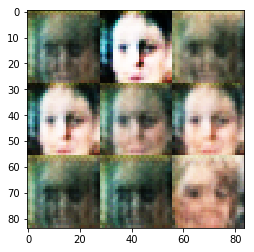

Step5410 Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 0.8917
Step5420 Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 0.9777
Step5430 Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.9301
Step5440 Epoch 1/1... Discriminator Loss: 0.9181... Generator Loss: 1.1949
Step5450 Epoch 1/1... Discriminator Loss: 0.9695... Generator Loss: 1.0648
Step5460 Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.3414
Step5470 Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.9406
Step5480 Epoch 1/1... Discriminator Loss: 0.8592... Generator Loss: 1.3925
Step5490 Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.8265
Step5500 Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.4491


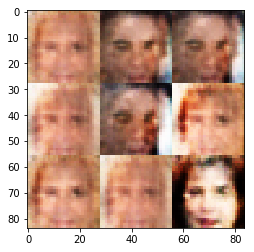

Step5510 Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.8522
Step5520 Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 1.4312
Step5530 Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8998
Step5540 Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.3880
Step5550 Epoch 1/1... Discriminator Loss: 0.9399... Generator Loss: 1.2427
Step5560 Epoch 1/1... Discriminator Loss: 1.0617... Generator Loss: 1.0875
Step5570 Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7175
Step5580 Epoch 1/1... Discriminator Loss: 0.8720... Generator Loss: 1.3795
Step5590 Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 1.4456
Step5600 Epoch 1/1... Discriminator Loss: 0.9087... Generator Loss: 1.0777


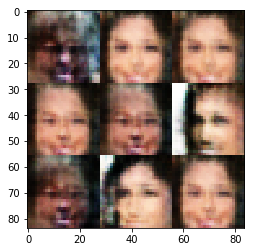

Step5610 Epoch 1/1... Discriminator Loss: 0.7436... Generator Loss: 1.4263
Step5620 Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 0.9895
Step5630 Epoch 1/1... Discriminator Loss: 0.8396... Generator Loss: 1.3776
Step5640 Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.1878
Step5650 Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.3323
Step5660 Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.7326
Step5670 Epoch 1/1... Discriminator Loss: 0.9359... Generator Loss: 1.3469
Step5680 Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.2812
Step5690 Epoch 1/1... Discriminator Loss: 1.2108... Generator Loss: 0.9833
Step5700 Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 1.0403


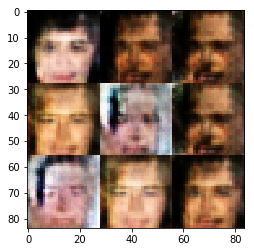

Step5710 Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1212
Step5720 Epoch 1/1... Discriminator Loss: 0.7289... Generator Loss: 1.4811
Step5730 Epoch 1/1... Discriminator Loss: 0.6601... Generator Loss: 1.6955
Step5740 Epoch 1/1... Discriminator Loss: 0.8655... Generator Loss: 1.2998
Step5750 Epoch 1/1... Discriminator Loss: 0.8594... Generator Loss: 1.3725
Step5760 Epoch 1/1... Discriminator Loss: 0.8860... Generator Loss: 1.0582
Step5770 Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.3218
Step5780 Epoch 1/1... Discriminator Loss: 0.9680... Generator Loss: 1.4448
Step5790 Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.0287
Step5800 Epoch 1/1... Discriminator Loss: 0.8840... Generator Loss: 1.2314


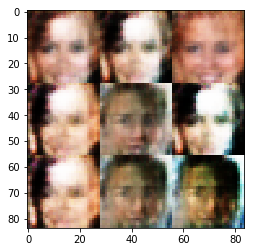

Step5810 Epoch 1/1... Discriminator Loss: 0.9669... Generator Loss: 1.2459
Step5820 Epoch 1/1... Discriminator Loss: 0.8717... Generator Loss: 1.1417
Step5830 Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.5082
Step5840 Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 1.4222
Step5850 Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 1.0905
Step5860 Epoch 1/1... Discriminator Loss: 0.7316... Generator Loss: 1.7273
Step5870 Epoch 1/1... Discriminator Loss: 0.6316... Generator Loss: 2.0842
Step5880 Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 1.3718
Step5890 Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.4718
Step5900 Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0190


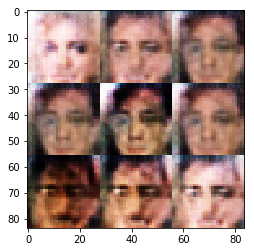

Step5910 Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.4815
Step5920 Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 0.9368
Step5930 Epoch 1/1... Discriminator Loss: 0.9780... Generator Loss: 1.3622
Step5940 Epoch 1/1... Discriminator Loss: 0.9377... Generator Loss: 1.5204
Step5950 Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.4253
Step5960 Epoch 1/1... Discriminator Loss: 1.1387... Generator Loss: 1.1705
Step5970 Epoch 1/1... Discriminator Loss: 0.8976... Generator Loss: 1.5059
Step5980 Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.6615
Step5990 Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.9647
Step6000 Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.0991


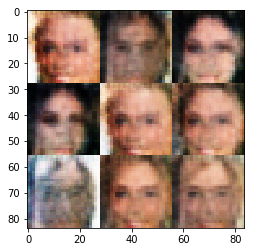

Step6010 Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 1.7532
Step6020 Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9467
Step6030 Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.7924
Step6040 Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.7400
Step6050 Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.0069
Step6060 Epoch 1/1... Discriminator Loss: 0.9623... Generator Loss: 0.9935
Step6070 Epoch 1/1... Discriminator Loss: 0.9859... Generator Loss: 1.0328
Step6080 Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 1.7342
Step6090 Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6862
Step6100 Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.1264


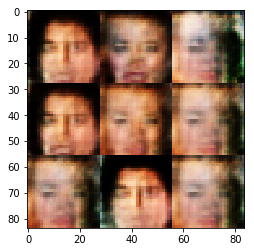

Step6110 Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.7731
Step6120 Epoch 1/1... Discriminator Loss: 0.8643... Generator Loss: 1.7004
Step6130 Epoch 1/1... Discriminator Loss: 0.8750... Generator Loss: 1.3436
Step6140 Epoch 1/1... Discriminator Loss: 0.9700... Generator Loss: 1.0170
Step6150 Epoch 1/1... Discriminator Loss: 0.7598... Generator Loss: 1.7052
Step6160 Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.2380
Step6170 Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 1.1450
Step6180 Epoch 1/1... Discriminator Loss: 0.6678... Generator Loss: 1.6602
Step6190 Epoch 1/1... Discriminator Loss: 0.8879... Generator Loss: 1.0599
Step6200 Epoch 1/1... Discriminator Loss: 0.9052... Generator Loss: 1.7688


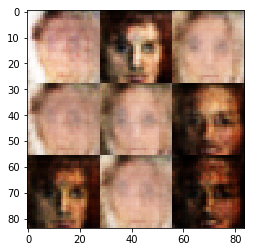

Step6210 Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.6651
Step6220 Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.0888
Step6230 Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.4047
Step6240 Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9242
Step6250 Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 1.9876
Step6260 Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.0815
Step6270 Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6445
Step6280 Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 1.4044
Step6290 Epoch 1/1... Discriminator Loss: 0.7255... Generator Loss: 1.4645
Step6300 Epoch 1/1... Discriminator Loss: 0.8392... Generator Loss: 1.2228


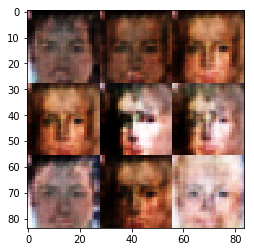

Step6310 Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9074
Step6320 Epoch 1/1... Discriminator Loss: 0.9082... Generator Loss: 1.2310
Step6330 Epoch 1/1... Discriminator Loss: 0.9633... Generator Loss: 1.1624
Step6340 Epoch 1/1... Discriminator Loss: 0.9982... Generator Loss: 1.3353
Step6350 Epoch 1/1... Discriminator Loss: 0.8541... Generator Loss: 1.2315
Step6360 Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 1.2385
Step6370 Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 1.0867
Step6380 Epoch 1/1... Discriminator Loss: 1.0035... Generator Loss: 1.1328
Step6390 Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.4677
Step6400 Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 1.0623


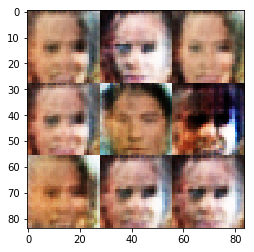

Step6410 Epoch 1/1... Discriminator Loss: 0.8358... Generator Loss: 1.7813
Step6420 Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.4248
Step6430 Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.9795
Step6440 Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 1.6030
Step6450 Epoch 1/1... Discriminator Loss: 1.0232... Generator Loss: 1.1375
Step6460 Epoch 1/1... Discriminator Loss: 0.7916... Generator Loss: 1.5324
Step6470 Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.5362
Step6480 Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.7335
Step6490 Epoch 1/1... Discriminator Loss: 1.4510... Generator Loss: 0.8639
Step6500 Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.1740


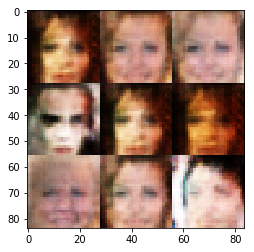

Step6510 Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 1.1657
Step6520 Epoch 1/1... Discriminator Loss: 0.9699... Generator Loss: 1.1075
Step6530 Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8245
Step6540 Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.6068
Step6550 Epoch 1/1... Discriminator Loss: 0.7484... Generator Loss: 1.4595
Step6560 Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.2757
Step6570 Epoch 1/1... Discriminator Loss: 0.9165... Generator Loss: 1.1567
Step6580 Epoch 1/1... Discriminator Loss: 0.8470... Generator Loss: 1.1823
Step6590 Epoch 1/1... Discriminator Loss: 0.7879... Generator Loss: 1.4183
Step6600 Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.3168


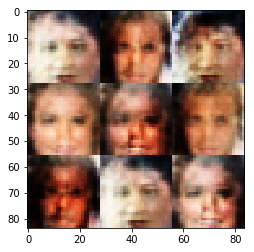

Step6610 Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 0.8377
Step6620 Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.8638
Step6630 Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.0191
Step6640 Epoch 1/1... Discriminator Loss: 0.8657... Generator Loss: 1.2872
Step6650 Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 1.2710
Step6660 Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.3451
Step6670 Epoch 1/1... Discriminator Loss: 0.7479... Generator Loss: 1.6233
Step6680 Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0021
Step6690 Epoch 1/1... Discriminator Loss: 0.7752... Generator Loss: 1.6068
Step6700 Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 0.8952


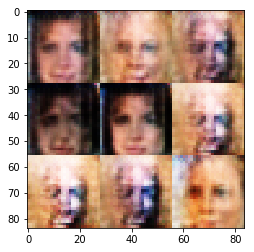

Step6710 Epoch 1/1... Discriminator Loss: 0.9373... Generator Loss: 1.4306
Step6720 Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.9854
Step6730 Epoch 1/1... Discriminator Loss: 0.8909... Generator Loss: 1.1894
Step6740 Epoch 1/1... Discriminator Loss: 0.8041... Generator Loss: 1.4640
Step6750 Epoch 1/1... Discriminator Loss: 0.7785... Generator Loss: 1.3376
Step6760 Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.3019
Step6770 Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 1.8483
Step6780 Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 1.2121
Step6790 Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.4504
Step6800 Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.7843


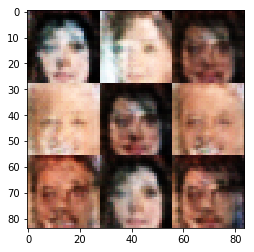

Step6810 Epoch 1/1... Discriminator Loss: 0.6940... Generator Loss: 1.6555
Step6820 Epoch 1/1... Discriminator Loss: 0.8020... Generator Loss: 1.2873
Step6830 Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0567
Step6840 Epoch 1/1... Discriminator Loss: 0.6700... Generator Loss: 1.5424
Step6850 Epoch 1/1... Discriminator Loss: 0.8834... Generator Loss: 1.1885
Step6860 Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.5561
Step6870 Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.4123
Step6880 Epoch 1/1... Discriminator Loss: 0.6819... Generator Loss: 1.4343
Step6890 Epoch 1/1... Discriminator Loss: 0.8173... Generator Loss: 1.3034
Step6900 Epoch 1/1... Discriminator Loss: 0.6947... Generator Loss: 1.8651


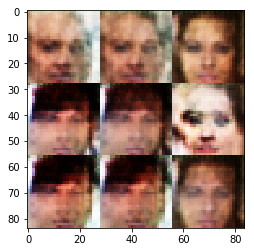

Step6910 Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 1.3874
Step6920 Epoch 1/1... Discriminator Loss: 0.7956... Generator Loss: 1.8956
Step6930 Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.4574
Step6940 Epoch 1/1... Discriminator Loss: 0.9382... Generator Loss: 1.4779
Step6950 Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.3479
Step6960 Epoch 1/1... Discriminator Loss: 0.8790... Generator Loss: 1.1002
Step6970 Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0730
Step6980 Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.7815
Step6990 Epoch 1/1... Discriminator Loss: 0.7677... Generator Loss: 1.4944
Step7000 Epoch 1/1... Discriminator Loss: 0.9306... Generator Loss: 1.0434


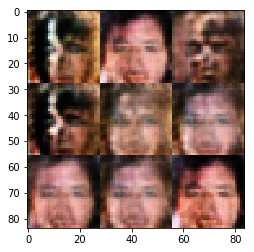

Step7010 Epoch 1/1... Discriminator Loss: 0.8471... Generator Loss: 1.3969
Step7020 Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 0.9286
Step7030 Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.2982
Step7040 Epoch 1/1... Discriminator Loss: 1.1453... Generator Loss: 1.0001
Step7050 Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.0739
Step7060 Epoch 1/1... Discriminator Loss: 0.8650... Generator Loss: 1.1688
Step7070 Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 1.2716
Step7080 Epoch 1/1... Discriminator Loss: 0.7852... Generator Loss: 1.4108
Step7090 Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 1.0215
Step7100 Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9882


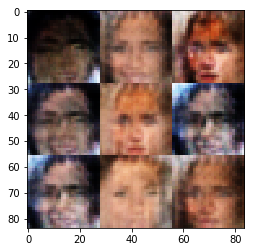

Step7110 Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1097
Step7120 Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 1.5201
Step7130 Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.0866
Step7140 Epoch 1/1... Discriminator Loss: 0.8955... Generator Loss: 1.2988
Step7150 Epoch 1/1... Discriminator Loss: 0.7013... Generator Loss: 1.7186
Step7160 Epoch 1/1... Discriminator Loss: 0.8705... Generator Loss: 1.2745
Step7170 Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.8263
Step7180 Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.3358
Step7190 Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.9683
Step7200 Epoch 1/1... Discriminator Loss: 0.7829... Generator Loss: 1.3213


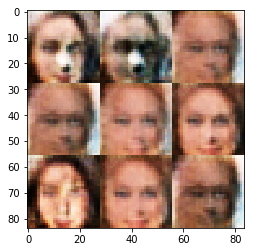

Step7210 Epoch 1/1... Discriminator Loss: 1.0547... Generator Loss: 1.1505
Step7220 Epoch 1/1... Discriminator Loss: 0.9272... Generator Loss: 1.1656
Step7230 Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8091
Step7240 Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 1.2691
Step7250 Epoch 1/1... Discriminator Loss: 0.9642... Generator Loss: 1.1508
Step7260 Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.1255
Step7270 Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.7946
Step7280 Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 1.6531
Step7290 Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 0.8959
Step7300 Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 1.4483


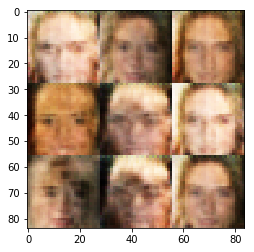

Step7310 Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8604
Step7320 Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 0.8106
Step7330 Epoch 1/1... Discriminator Loss: 0.8025... Generator Loss: 1.5333
Step7340 Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.4654
Step7350 Epoch 1/1... Discriminator Loss: 0.8016... Generator Loss: 1.4459
Step7360 Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.9479
Step7370 Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.7928
Step7380 Epoch 1/1... Discriminator Loss: 1.0401... Generator Loss: 1.1963
Step7390 Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.1604
Step7400 Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.9187


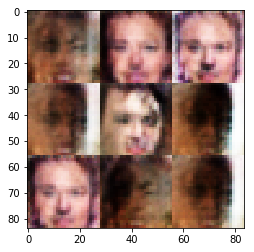

Step7410 Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 1.0481
Step7420 Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 1.5342
Step7430 Epoch 1/1... Discriminator Loss: 0.8245... Generator Loss: 1.3841
Step7440 Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 0.9344
Step7450 Epoch 1/1... Discriminator Loss: 1.1886... Generator Loss: 0.8031
Step7460 Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 1.0612
Step7470 Epoch 1/1... Discriminator Loss: 0.7832... Generator Loss: 1.5457
Step7480 Epoch 1/1... Discriminator Loss: 0.8877... Generator Loss: 1.4772
Step7490 Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.0628
Step7500 Epoch 1/1... Discriminator Loss: 0.8615... Generator Loss: 1.2778


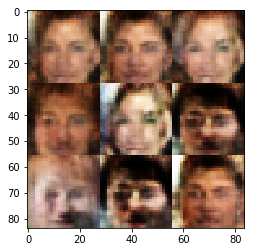

Step7510 Epoch 1/1... Discriminator Loss: 1.0748... Generator Loss: 0.9952
Step7520 Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 1.0807
Step7530 Epoch 1/1... Discriminator Loss: 0.8728... Generator Loss: 1.2322
Step7540 Epoch 1/1... Discriminator Loss: 0.8852... Generator Loss: 1.1966
Step7550 Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.0314
Step7560 Epoch 1/1... Discriminator Loss: 0.9207... Generator Loss: 1.3485
Step7570 Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8289
Step7580 Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 1.4368
Step7590 Epoch 1/1... Discriminator Loss: 1.0066... Generator Loss: 1.0940
Step7600 Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 1.3215


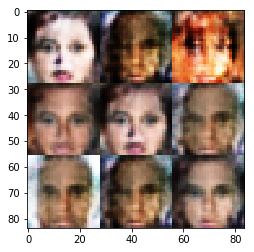

Step7610 Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.2426
Step7620 Epoch 1/1... Discriminator Loss: 1.0332... Generator Loss: 0.9576
Step7630 Epoch 1/1... Discriminator Loss: 0.9759... Generator Loss: 1.0764
Step7640 Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 1.1400
Step7650 Epoch 1/1... Discriminator Loss: 1.1760... Generator Loss: 0.9611
Step7660 Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 1.2259
Step7670 Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.0485
Step7680 Epoch 1/1... Discriminator Loss: 0.8159... Generator Loss: 1.5920
Step7690 Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.2709
Step7700 Epoch 1/1... Discriminator Loss: 0.8847... Generator Loss: 1.4086


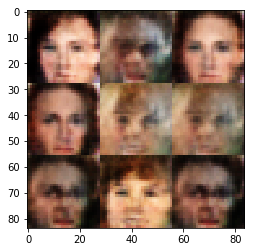

Step7710 Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 0.7719
Step7720 Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.0634
Step7730 Epoch 1/1... Discriminator Loss: 0.9451... Generator Loss: 1.4714
Step7740 Epoch 1/1... Discriminator Loss: 0.7059... Generator Loss: 2.1015
Step7750 Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.8140
Step7760 Epoch 1/1... Discriminator Loss: 0.8524... Generator Loss: 1.5314
Step7770 Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.0978
Step7780 Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.9342
Step7790 Epoch 1/1... Discriminator Loss: 0.8295... Generator Loss: 1.3941
Step7800 Epoch 1/1... Discriminator Loss: 1.0701... Generator Loss: 1.1140


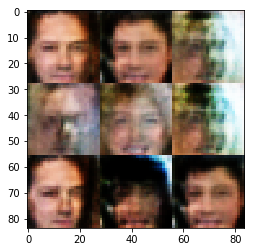

Step7810 Epoch 1/1... Discriminator Loss: 0.7788... Generator Loss: 1.4600
Step7820 Epoch 1/1... Discriminator Loss: 0.9161... Generator Loss: 1.5948
Step7830 Epoch 1/1... Discriminator Loss: 0.7178... Generator Loss: 1.5406
Step7840 Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.9094
Step7850 Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2921
Step7860 Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 1.0081
Step7870 Epoch 1/1... Discriminator Loss: 1.0064... Generator Loss: 1.1008
Step7880 Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.8870
Step7890 Epoch 1/1... Discriminator Loss: 0.9442... Generator Loss: 1.2975
Step7900 Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.3342


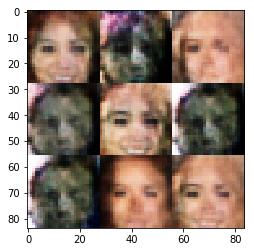

Step7910 Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.1732
Step7920 Epoch 1/1... Discriminator Loss: 0.8889... Generator Loss: 1.2976
Step7930 Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.9851
Step7940 Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0724
Step7950 Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.9202
Step7960 Epoch 1/1... Discriminator Loss: 1.0238... Generator Loss: 1.1435
Step7970 Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 1.0649
Step7980 Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 1.2158
Step7990 Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.9634
Step8000 Epoch 1/1... Discriminator Loss: 1.0825... Generator Loss: 0.9473


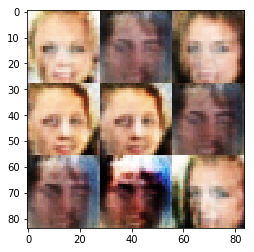

Step8010 Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.1632
Step8020 Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.3528
Step8030 Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.1227
Step8040 Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.2017
Step8050 Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.2264
Step8060 Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.5484
Step8070 Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.6830
Step8080 Epoch 1/1... Discriminator Loss: 0.7966... Generator Loss: 1.3171
Step8090 Epoch 1/1... Discriminator Loss: 0.9758... Generator Loss: 1.0567
Step8100 Epoch 1/1... Discriminator Loss: 0.8907... Generator Loss: 1.2331


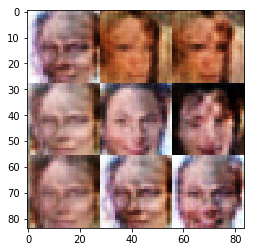

Step8110 Epoch 1/1... Discriminator Loss: 1.1262... Generator Loss: 0.8818
Step8120 Epoch 1/1... Discriminator Loss: 0.9733... Generator Loss: 1.1979
Step8130 Epoch 1/1... Discriminator Loss: 0.8533... Generator Loss: 1.3157
Step8140 Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 1.0493
Step8150 Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.6880
Step8160 Epoch 1/1... Discriminator Loss: 1.0322... Generator Loss: 1.0756
Step8170 Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 1.3317
Step8180 Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.2325
Step8190 Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 1.1482
Step8200 Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 1.4005


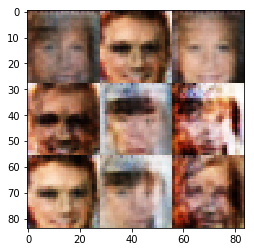

Step8210 Epoch 1/1... Discriminator Loss: 1.0148... Generator Loss: 0.9428
Step8220 Epoch 1/1... Discriminator Loss: 1.2042... Generator Loss: 0.6447
Step8230 Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6462
Step8240 Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.4932
Step8250 Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.5371
Step8260 Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.3120
Step8270 Epoch 1/1... Discriminator Loss: 1.1093... Generator Loss: 0.7916
Step8280 Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.5336
Step8290 Epoch 1/1... Discriminator Loss: 0.7772... Generator Loss: 1.4616
Step8300 Epoch 1/1... Discriminator Loss: 0.9781... Generator Loss: 0.9910


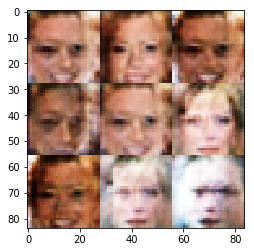

Step8310 Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.6696
Step8320 Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 0.8779
Step8330 Epoch 1/1... Discriminator Loss: 0.8293... Generator Loss: 1.4929
Step8340 Epoch 1/1... Discriminator Loss: 1.0712... Generator Loss: 0.9219
Step8350 Epoch 1/1... Discriminator Loss: 1.0157... Generator Loss: 1.2477
Step8360 Epoch 1/1... Discriminator Loss: 1.1021... Generator Loss: 0.8813
Step8370 Epoch 1/1... Discriminator Loss: 0.9901... Generator Loss: 1.1558
Step8380 Epoch 1/1... Discriminator Loss: 0.8694... Generator Loss: 1.2529
Step8390 Epoch 1/1... Discriminator Loss: 0.9098... Generator Loss: 1.5937
Step8400 Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.1093


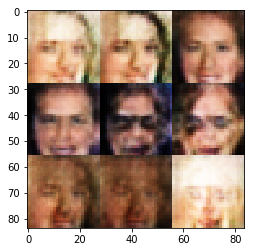

Step8410 Epoch 1/1... Discriminator Loss: 0.9366... Generator Loss: 1.2151
Step8420 Epoch 1/1... Discriminator Loss: 0.9369... Generator Loss: 1.2691
Step8430 Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.3667
Step8440 Epoch 1/1... Discriminator Loss: 1.0971... Generator Loss: 0.8942
Step8450 Epoch 1/1... Discriminator Loss: 0.8309... Generator Loss: 1.4067
Step8460 Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.9927
Step8470 Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 1.5015
Step8480 Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.1585
Step8490 Epoch 1/1... Discriminator Loss: 0.9634... Generator Loss: 1.3807
Step8500 Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0828


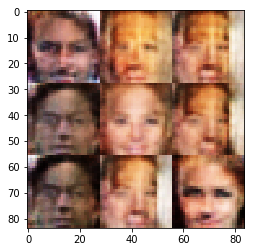

Step8510 Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 1.1727
Step8520 Epoch 1/1... Discriminator Loss: 0.9694... Generator Loss: 1.0285
Step8530 Epoch 1/1... Discriminator Loss: 0.9909... Generator Loss: 1.2121
Step8540 Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6352
Step8550 Epoch 1/1... Discriminator Loss: 0.8370... Generator Loss: 1.4930
Step8560 Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.2318
Step8570 Epoch 1/1... Discriminator Loss: 0.9736... Generator Loss: 1.0989
Step8580 Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.8923
Step8590 Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.2966
Step8600 Epoch 1/1... Discriminator Loss: 1.0278... Generator Loss: 1.0778


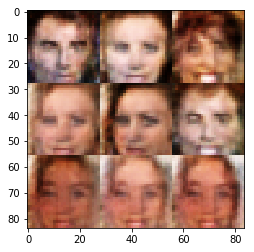

Step8610 Epoch 1/1... Discriminator Loss: 1.0225... Generator Loss: 0.9233
Step8620 Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 1.1007
Step8630 Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 0.7491
Step8640 Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.1926
Step8650 Epoch 1/1... Discriminator Loss: 0.9486... Generator Loss: 0.9691
Step8660 Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.3525
Step8670 Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 1.4459
Step8680 Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9067
Step8690 Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.0549
Step8700 Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.1745


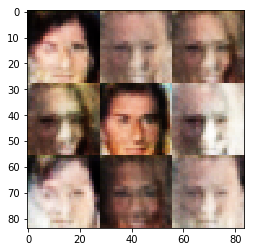

Step8710 Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6099
Step8720 Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.5983
Step8730 Epoch 1/1... Discriminator Loss: 0.8678... Generator Loss: 1.3979
Step8740 Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.8355
Step8750 Epoch 1/1... Discriminator Loss: 0.8695... Generator Loss: 1.2240
Step8760 Epoch 1/1... Discriminator Loss: 1.0966... Generator Loss: 1.4590
Step8770 Epoch 1/1... Discriminator Loss: 0.9770... Generator Loss: 1.3309
Step8780 Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 1.0602
Step8790 Epoch 1/1... Discriminator Loss: 0.8580... Generator Loss: 1.8199
Step8800 Epoch 1/1... Discriminator Loss: 1.0314... Generator Loss: 0.9037


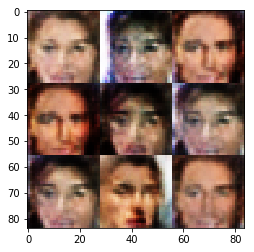

Step8810 Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.0815
Step8820 Epoch 1/1... Discriminator Loss: 0.8802... Generator Loss: 1.4756
Step8830 Epoch 1/1... Discriminator Loss: 0.6577... Generator Loss: 1.8783
Step8840 Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.8093
Step8850 Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.1456
Step8860 Epoch 1/1... Discriminator Loss: 0.7890... Generator Loss: 1.5643
Step8870 Epoch 1/1... Discriminator Loss: 0.7622... Generator Loss: 1.4161
Step8880 Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.8250
Step8890 Epoch 1/1... Discriminator Loss: 0.9186... Generator Loss: 1.0995
Step8900 Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.0143


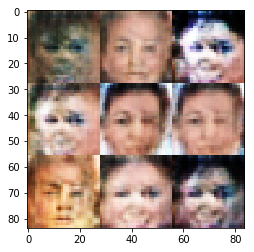

Step8910 Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1377
Step8920 Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.9244
Step8930 Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.6891
Step8940 Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.2087
Step8950 Epoch 1/1... Discriminator Loss: 0.9706... Generator Loss: 1.0614
Step8960 Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.6352
Step8970 Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.0695
Step8980 Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 0.9356
Step8990 Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.3007
Step9000 Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.7340


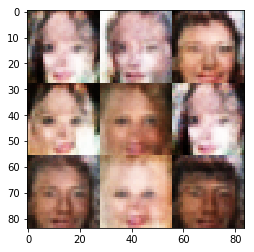

Step9010 Epoch 1/1... Discriminator Loss: 0.9917... Generator Loss: 1.0900
Step9020 Epoch 1/1... Discriminator Loss: 0.8806... Generator Loss: 1.4925
Step9030 Epoch 1/1... Discriminator Loss: 0.9032... Generator Loss: 1.4019
Step9040 Epoch 1/1... Discriminator Loss: 1.0010... Generator Loss: 1.1418
Step9050 Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.9680
Step9060 Epoch 1/1... Discriminator Loss: 1.0110... Generator Loss: 1.1235
Step9070 Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.3578
Step9080 Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 0.9831
Step9090 Epoch 1/1... Discriminator Loss: 1.0886... Generator Loss: 1.0441
Step9100 Epoch 1/1... Discriminator Loss: 0.9452... Generator Loss: 1.4274


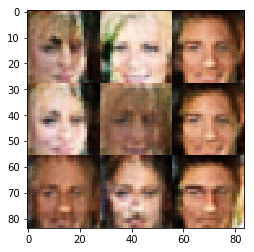

Step9110 Epoch 1/1... Discriminator Loss: 1.1339... Generator Loss: 0.8320
Step9120 Epoch 1/1... Discriminator Loss: 0.7972... Generator Loss: 1.4623
Step9130 Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 0.8725
Step9140 Epoch 1/1... Discriminator Loss: 0.9116... Generator Loss: 1.3760
Step9150 Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.2797
Step9160 Epoch 1/1... Discriminator Loss: 0.8563... Generator Loss: 1.2517
Step9170 Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.9624
Step9180 Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 1.5194
Step9190 Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.1280
Step9200 Epoch 1/1... Discriminator Loss: 0.9799... Generator Loss: 1.0136


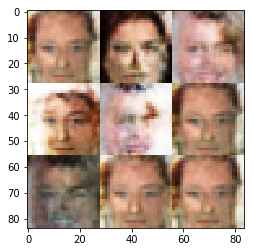

Step9210 Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.5958
Step9220 Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 1.0843
Step9230 Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.3127
Step9240 Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.0560
Step9250 Epoch 1/1... Discriminator Loss: 0.7886... Generator Loss: 1.4962
Step9260 Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 1.1626
Step9270 Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.7686
Step9280 Epoch 1/1... Discriminator Loss: 1.0775... Generator Loss: 1.0303
Step9290 Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 1.2253
Step9300 Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.1906


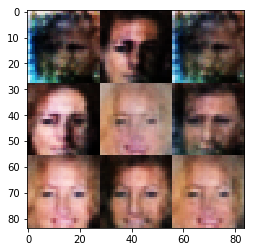

Step9310 Epoch 1/1... Discriminator Loss: 0.8316... Generator Loss: 1.4657
Step9320 Epoch 1/1... Discriminator Loss: 0.9261... Generator Loss: 1.4222
Step9330 Epoch 1/1... Discriminator Loss: 0.9339... Generator Loss: 1.4797
Step9340 Epoch 1/1... Discriminator Loss: 0.9009... Generator Loss: 1.3487
Step9350 Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 0.9207
Step9360 Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.7649
Step9370 Epoch 1/1... Discriminator Loss: 1.1704... Generator Loss: 0.7401
Step9380 Epoch 1/1... Discriminator Loss: 1.0272... Generator Loss: 0.9368
Step9390 Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.3832
Step9400 Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7223


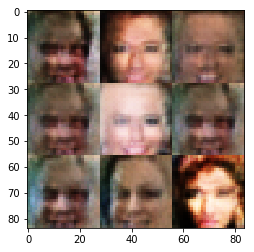

Step9410 Epoch 1/1... Discriminator Loss: 0.8971... Generator Loss: 1.4939
Step9420 Epoch 1/1... Discriminator Loss: 0.8921... Generator Loss: 1.5177
Step9430 Epoch 1/1... Discriminator Loss: 0.7019... Generator Loss: 1.9306
Step9440 Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.1557
Step9450 Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.2203
Step9460 Epoch 1/1... Discriminator Loss: 0.8691... Generator Loss: 1.2633
Step9470 Epoch 1/1... Discriminator Loss: 0.8335... Generator Loss: 1.4837
Step9480 Epoch 1/1... Discriminator Loss: 0.8384... Generator Loss: 1.3349
Step9490 Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0242
Step9500 Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.5217


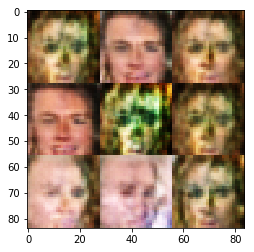

Step9510 Epoch 1/1... Discriminator Loss: 0.8680... Generator Loss: 1.6080
Step9520 Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 1.3251
Step9530 Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 1.4963
Step9540 Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 1.7543
Step9550 Epoch 1/1... Discriminator Loss: 0.6798... Generator Loss: 1.7411
Step9560 Epoch 1/1... Discriminator Loss: 0.7769... Generator Loss: 1.4065
Step9570 Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.1761
Step9580 Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.7084
Step9590 Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.8999
Step9600 Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.0395


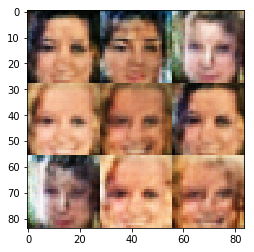

Step9610 Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 1.6177
Step9620 Epoch 1/1... Discriminator Loss: 1.1506... Generator Loss: 0.7847
Step9630 Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.3097
Step9640 Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.2412
Step9650 Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.3447
Step9660 Epoch 1/1... Discriminator Loss: 0.9649... Generator Loss: 1.0321
Step9670 Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 1.3087
Step9680 Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.2635
Step9690 Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 0.9691
Step9700 Epoch 1/1... Discriminator Loss: 0.8438... Generator Loss: 1.5127


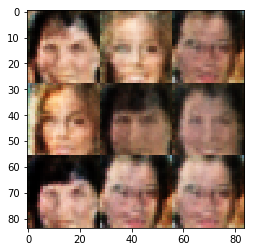

Step9710 Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 0.9613
Step9720 Epoch 1/1... Discriminator Loss: 0.7352... Generator Loss: 1.4658
Step9730 Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.4666
Step9740 Epoch 1/1... Discriminator Loss: 1.0237... Generator Loss: 0.9346
Step9750 Epoch 1/1... Discriminator Loss: 1.0247... Generator Loss: 1.1039
Step9760 Epoch 1/1... Discriminator Loss: 0.9384... Generator Loss: 1.2336
Step9770 Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 1.1589
Step9780 Epoch 1/1... Discriminator Loss: 1.0335... Generator Loss: 1.1558
Step9790 Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.9907
Step9800 Epoch 1/1... Discriminator Loss: 0.9592... Generator Loss: 1.0379


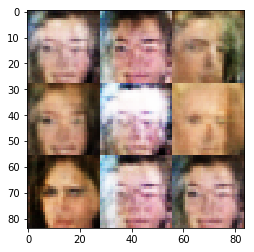

Step9810 Epoch 1/1... Discriminator Loss: 0.7965... Generator Loss: 1.4453
Step9820 Epoch 1/1... Discriminator Loss: 1.0386... Generator Loss: 0.9036
Step9830 Epoch 1/1... Discriminator Loss: 0.8066... Generator Loss: 1.2831
Step9840 Epoch 1/1... Discriminator Loss: 0.9368... Generator Loss: 1.1283
Step9850 Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 1.4425
Step9860 Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 1.0103
Step9870 Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 0.6929
Step9880 Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 1.1450
Step9890 Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 1.0338
Step9900 Epoch 1/1... Discriminator Loss: 0.8354... Generator Loss: 1.6778


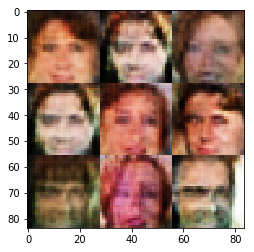

Step9910 Epoch 1/1... Discriminator Loss: 0.7713... Generator Loss: 1.3715
Step9920 Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.4687
Step9930 Epoch 1/1... Discriminator Loss: 0.9484... Generator Loss: 0.9586
Step9940 Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8915
Step9950 Epoch 1/1... Discriminator Loss: 0.8152... Generator Loss: 1.5375
Step9960 Epoch 1/1... Discriminator Loss: 1.1008... Generator Loss: 1.1029
Step9970 Epoch 1/1... Discriminator Loss: 0.9713... Generator Loss: 1.0744
Step9980 Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 1.5588
Step9990 Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 1.5920
Step10000 Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7725


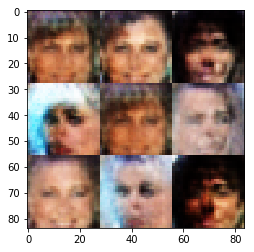

Step10010 Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.7552
Step10020 Epoch 1/1... Discriminator Loss: 0.9265... Generator Loss: 1.2757
Step10030 Epoch 1/1... Discriminator Loss: 0.8516... Generator Loss: 1.1460
Step10040 Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.3719
Step10050 Epoch 1/1... Discriminator Loss: 0.8492... Generator Loss: 1.1151
Step10060 Epoch 1/1... Discriminator Loss: 0.8890... Generator Loss: 1.2586
Step10070 Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.5583
Step10080 Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 1.3070
Step10090 Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 1.0303
Step10100 Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.2824


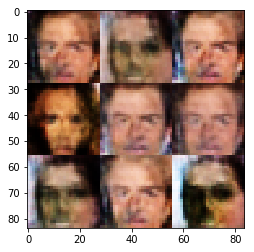

Step10110 Epoch 1/1... Discriminator Loss: 1.2961... Generator Loss: 0.6733
Step10120 Epoch 1/1... Discriminator Loss: 1.1122... Generator Loss: 0.8512
Step10130 Epoch 1/1... Discriminator Loss: 0.8057... Generator Loss: 1.4011
Step10140 Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 1.8402
Step10150 Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 1.7606
Step10160 Epoch 1/1... Discriminator Loss: 0.9317... Generator Loss: 1.0896
Step10170 Epoch 1/1... Discriminator Loss: 1.0492... Generator Loss: 1.1018
Step10180 Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.9317
Step10190 Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 1.1833
Step10200 Epoch 1/1... Discriminator Loss: 0.6668... Generator Loss: 2.1355


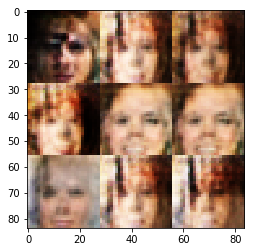

Step10210 Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.5747
Step10220 Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.8204
Step10230 Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.3131
Step10240 Epoch 1/1... Discriminator Loss: 1.1692... Generator Loss: 0.8356
Step10250 Epoch 1/1... Discriminator Loss: 0.7507... Generator Loss: 1.4317
Step10260 Epoch 1/1... Discriminator Loss: 1.1391... Generator Loss: 0.9029
Step10270 Epoch 1/1... Discriminator Loss: 1.0060... Generator Loss: 1.1265
Step10280 Epoch 1/1... Discriminator Loss: 0.7483... Generator Loss: 1.4530
Step10290 Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 1.1055
Step10300 Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.8733


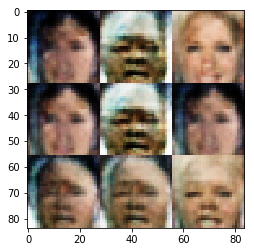

Step10310 Epoch 1/1... Discriminator Loss: 0.7295... Generator Loss: 1.6434
Step10320 Epoch 1/1... Discriminator Loss: 0.8352... Generator Loss: 1.5314
Step10330 Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.9168
Step10340 Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 2.1243
Step10350 Epoch 1/1... Discriminator Loss: 0.8002... Generator Loss: 1.4038
Step10360 Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6159
Step10370 Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.4499
Step10380 Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 1.0970
Step10390 Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.3181
Step10400 Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 1.0368


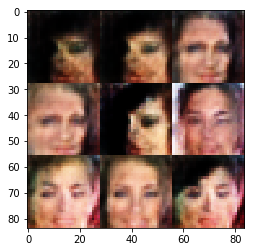

Step10410 Epoch 1/1... Discriminator Loss: 0.8677... Generator Loss: 1.2688
Step10420 Epoch 1/1... Discriminator Loss: 0.8904... Generator Loss: 1.1979
Step10430 Epoch 1/1... Discriminator Loss: 0.7633... Generator Loss: 1.4739
Step10440 Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9116
Step10450 Epoch 1/1... Discriminator Loss: 1.1734... Generator Loss: 1.1830
Step10460 Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 1.1918
Step10470 Epoch 1/1... Discriminator Loss: 0.8357... Generator Loss: 1.5221
Step10480 Epoch 1/1... Discriminator Loss: 1.0104... Generator Loss: 1.0870
Step10490 Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 2.0753
Step10500 Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 1.7088


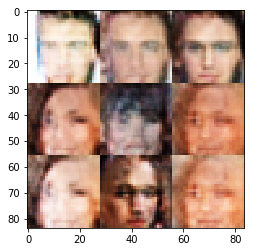

Step10510 Epoch 1/1... Discriminator Loss: 0.6907... Generator Loss: 1.8530
Step10520 Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.0273
Step10530 Epoch 1/1... Discriminator Loss: 0.7292... Generator Loss: 1.4776
Step10540 Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.3609
Step10550 Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.0701
Step10560 Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9382
Step10570 Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.6304
Step10580 Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.7926
Step10590 Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 0.8879
Step10600 Epoch 1/1... Discriminator Loss: 0.9989... Generator Loss: 1.0851


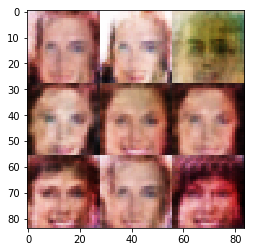

Step10610 Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.8304
Step10620 Epoch 1/1... Discriminator Loss: 0.8518... Generator Loss: 1.3707
Step10630 Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.2973
Step10640 Epoch 1/1... Discriminator Loss: 0.7789... Generator Loss: 1.2561
Step10650 Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.2180
Step10660 Epoch 1/1... Discriminator Loss: 0.7578... Generator Loss: 1.4098
Step10670 Epoch 1/1... Discriminator Loss: 1.0227... Generator Loss: 0.8685
Step10680 Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.3257
Step10690 Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.1812
Step10700 Epoch 1/1... Discriminator Loss: 0.8995... Generator Loss: 1.4364


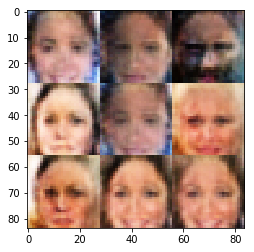

Step10710 Epoch 1/1... Discriminator Loss: 0.8268... Generator Loss: 1.2469
Step10720 Epoch 1/1... Discriminator Loss: 0.7159... Generator Loss: 1.6242
Step10730 Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.8456
Step10740 Epoch 1/1... Discriminator Loss: 0.7131... Generator Loss: 1.8287
Step10750 Epoch 1/1... Discriminator Loss: 0.8734... Generator Loss: 1.4219
Step10760 Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 0.9617
Step10770 Epoch 1/1... Discriminator Loss: 0.6882... Generator Loss: 1.9197
Step10780 Epoch 1/1... Discriminator Loss: 0.6890... Generator Loss: 1.9435
Step10790 Epoch 1/1... Discriminator Loss: 0.7017... Generator Loss: 1.5699
Step10800 Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.5230


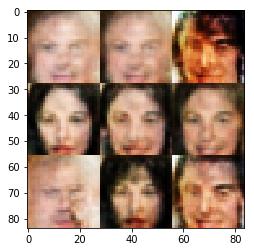

Step10810 Epoch 1/1... Discriminator Loss: 0.8083... Generator Loss: 1.4107
Step10820 Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.1724
Step10830 Epoch 1/1... Discriminator Loss: 0.8206... Generator Loss: 1.5763
Step10840 Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.3351
Step10850 Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.2519
Step10860 Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 0.9932
Step10870 Epoch 1/1... Discriminator Loss: 0.8401... Generator Loss: 1.4348
Step10880 Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.2099
Step10890 Epoch 1/1... Discriminator Loss: 0.8297... Generator Loss: 1.1799
Step10900 Epoch 1/1... Discriminator Loss: 1.0517... Generator Loss: 1.4249


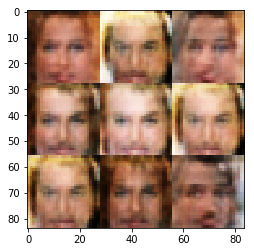

Step10910 Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.7509
Step10920 Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.1621
Step10930 Epoch 1/1... Discriminator Loss: 0.8027... Generator Loss: 1.4006
Step10940 Epoch 1/1... Discriminator Loss: 0.8009... Generator Loss: 1.4258
Step10950 Epoch 1/1... Discriminator Loss: 0.7068... Generator Loss: 2.0597
Step10960 Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.2640
Step10970 Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.6644
Step10980 Epoch 1/1... Discriminator Loss: 1.0619... Generator Loss: 1.1692
Step10990 Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 2.2754
Step11000 Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 1.0116


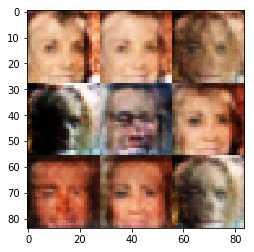

Step11010 Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.1804
Step11020 Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.7401
Step11030 Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.1857
Step11040 Epoch 1/1... Discriminator Loss: 0.9942... Generator Loss: 0.9303
Step11050 Epoch 1/1... Discriminator Loss: 1.0165... Generator Loss: 1.1959
Step11060 Epoch 1/1... Discriminator Loss: 0.9992... Generator Loss: 0.9168
Step11070 Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.2440
Step11080 Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0519
Step11090 Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.4511
Step11100 Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 0.9624


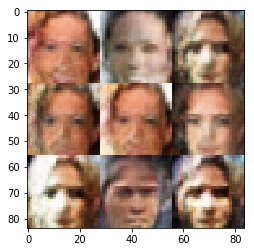

Step11110 Epoch 1/1... Discriminator Loss: 1.3632... Generator Loss: 0.9789
Step11120 Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.1265
Step11130 Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.0600
Step11140 Epoch 1/1... Discriminator Loss: 0.7299... Generator Loss: 1.5677
Step11150 Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.3075
Step11160 Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.2356
Step11170 Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.1675
Step11180 Epoch 1/1... Discriminator Loss: 0.7831... Generator Loss: 1.5367
Step11190 Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8772
Step11200 Epoch 1/1... Discriminator Loss: 0.8366... Generator Loss: 1.2326


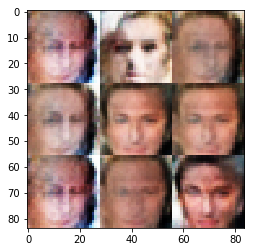

Step11210 Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.7835
Step11220 Epoch 1/1... Discriminator Loss: 0.8898... Generator Loss: 1.3778
Step11230 Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.3203
Step11240 Epoch 1/1... Discriminator Loss: 0.8901... Generator Loss: 1.1793
Step11250 Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.9214
Step11260 Epoch 1/1... Discriminator Loss: 0.6847... Generator Loss: 1.8713
Step11270 Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 1.0508
Step11280 Epoch 1/1... Discriminator Loss: 0.7103... Generator Loss: 1.6011
Step11290 Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.2223
Step11300 Epoch 1/1... Discriminator Loss: 0.9502... Generator Loss: 1.0450


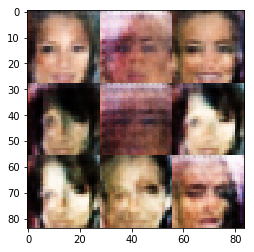

Step11310 Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.2874
Step11320 Epoch 1/1... Discriminator Loss: 0.6248... Generator Loss: 1.8312
Step11330 Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.0807
Step11340 Epoch 1/1... Discriminator Loss: 0.7129... Generator Loss: 1.9152
Step11350 Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.6345
Step11360 Epoch 1/1... Discriminator Loss: 0.7990... Generator Loss: 1.5255
Step11370 Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.2882
Step11380 Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 1.2778
Step11390 Epoch 1/1... Discriminator Loss: 0.9196... Generator Loss: 1.1924
Step11400 Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.2865


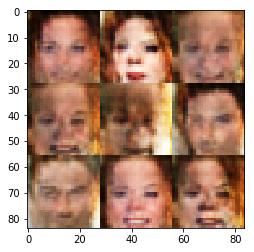

Step11410 Epoch 1/1... Discriminator Loss: 0.8029... Generator Loss: 1.9170
Step11420 Epoch 1/1... Discriminator Loss: 0.9095... Generator Loss: 1.1425
Step11430 Epoch 1/1... Discriminator Loss: 0.9310... Generator Loss: 1.2178
Step11440 Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.3432
Step11450 Epoch 1/1... Discriminator Loss: 0.6910... Generator Loss: 1.8520
Step11460 Epoch 1/1... Discriminator Loss: 0.8930... Generator Loss: 1.5384
Step11470 Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.6849
Step11480 Epoch 1/1... Discriminator Loss: 0.6389... Generator Loss: 1.9140
Step11490 Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.9698
Step11500 Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 1.0098


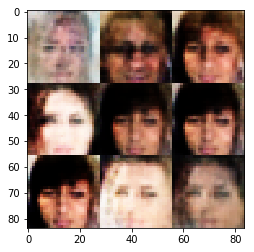

Step11510 Epoch 1/1... Discriminator Loss: 0.8373... Generator Loss: 1.3111
Step11520 Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 1.2190
Step11530 Epoch 1/1... Discriminator Loss: 1.2118... Generator Loss: 0.9026
Step11540 Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 1.5110
Step11550 Epoch 1/1... Discriminator Loss: 1.0880... Generator Loss: 0.8728
Step11560 Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.2309
Step11570 Epoch 1/1... Discriminator Loss: 0.8498... Generator Loss: 1.1654
Step11580 Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.9123
Step11590 Epoch 1/1... Discriminator Loss: 1.6082... Generator Loss: 0.6227
Step11600 Epoch 1/1... Discriminator Loss: 1.1593... Generator Loss: 0.9023


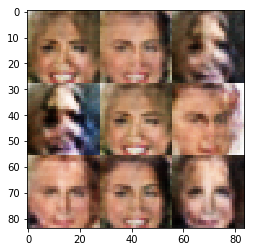

Step11610 Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.2588
Step11620 Epoch 1/1... Discriminator Loss: 0.9240... Generator Loss: 1.1843
Step11630 Epoch 1/1... Discriminator Loss: 0.7856... Generator Loss: 1.2508
Step11640 Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 0.8177
Step11650 Epoch 1/1... Discriminator Loss: 0.9060... Generator Loss: 1.3936
Step11660 Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.2088
Step11670 Epoch 1/1... Discriminator Loss: 0.8572... Generator Loss: 1.2310
Step11680 Epoch 1/1... Discriminator Loss: 0.8653... Generator Loss: 1.5500
Step11690 Epoch 1/1... Discriminator Loss: 0.9459... Generator Loss: 1.2434
Step11700 Epoch 1/1... Discriminator Loss: 0.7987... Generator Loss: 1.8020


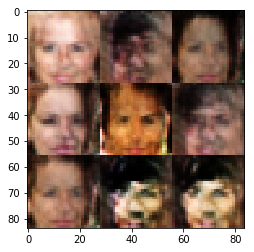

Step11710 Epoch 1/1... Discriminator Loss: 0.7339... Generator Loss: 1.3949
Step11720 Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.5233
Step11730 Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.6448
Step11740 Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.4647
Step11750 Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.3663
Step11760 Epoch 1/1... Discriminator Loss: 0.8549... Generator Loss: 1.4873
Step11770 Epoch 1/1... Discriminator Loss: 0.8888... Generator Loss: 1.4461
Step11780 Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.0337
Step11790 Epoch 1/1... Discriminator Loss: 0.7551... Generator Loss: 1.5243
Step11800 Epoch 1/1... Discriminator Loss: 0.9197... Generator Loss: 1.0364


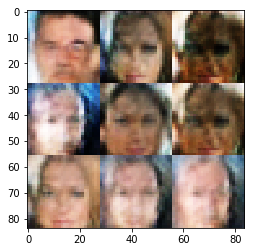

Step11810 Epoch 1/1... Discriminator Loss: 0.9867... Generator Loss: 1.0386
Step11820 Epoch 1/1... Discriminator Loss: 0.8162... Generator Loss: 1.2978
Step11830 Epoch 1/1... Discriminator Loss: 0.8749... Generator Loss: 1.6698
Step11840 Epoch 1/1... Discriminator Loss: 0.6989... Generator Loss: 1.4326
Step11850 Epoch 1/1... Discriminator Loss: 0.6948... Generator Loss: 1.6366
Step11860 Epoch 1/1... Discriminator Loss: 0.6966... Generator Loss: 1.6190
Step11870 Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.3889
Step11880 Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.4902
Step11890 Epoch 1/1... Discriminator Loss: 0.6946... Generator Loss: 1.4469
Step11900 Epoch 1/1... Discriminator Loss: 0.8988... Generator Loss: 1.1921


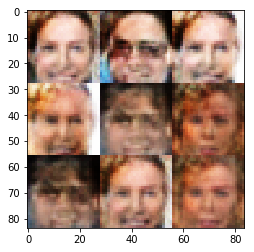

Step11910 Epoch 1/1... Discriminator Loss: 1.0449... Generator Loss: 1.0445
Step11920 Epoch 1/1... Discriminator Loss: 0.9127... Generator Loss: 1.3017
Step11930 Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.0659
Step11940 Epoch 1/1... Discriminator Loss: 0.9299... Generator Loss: 1.1067
Step11950 Epoch 1/1... Discriminator Loss: 0.7208... Generator Loss: 1.7389
Step11960 Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.0360
Step11970 Epoch 1/1... Discriminator Loss: 0.7821... Generator Loss: 1.6761
Step11980 Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 1.7768
Step11990 Epoch 1/1... Discriminator Loss: 0.8230... Generator Loss: 1.1740
Step12000 Epoch 1/1... Discriminator Loss: 1.0240... Generator Loss: 1.0103


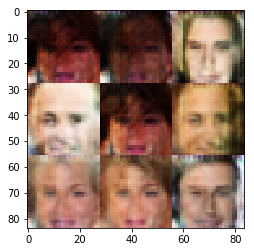

Step12010 Epoch 1/1... Discriminator Loss: 1.1076... Generator Loss: 0.7796
Step12020 Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.3614
Step12030 Epoch 1/1... Discriminator Loss: 0.8086... Generator Loss: 1.4799
Step12040 Epoch 1/1... Discriminator Loss: 0.8259... Generator Loss: 1.3935
Step12050 Epoch 1/1... Discriminator Loss: 0.6103... Generator Loss: 2.0980
Step12060 Epoch 1/1... Discriminator Loss: 0.8900... Generator Loss: 1.7277
Step12070 Epoch 1/1... Discriminator Loss: 1.1409... Generator Loss: 1.1135
Step12080 Epoch 1/1... Discriminator Loss: 0.8191... Generator Loss: 1.8853
Step12090 Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.7027
Step12100 Epoch 1/1... Discriminator Loss: 0.6234... Generator Loss: 2.1263


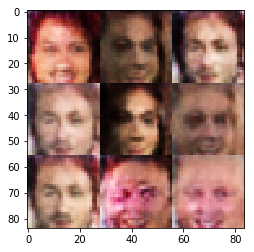

Step12110 Epoch 1/1... Discriminator Loss: 0.9601... Generator Loss: 1.0960
Step12120 Epoch 1/1... Discriminator Loss: 0.7307... Generator Loss: 1.3354
Step12130 Epoch 1/1... Discriminator Loss: 0.7639... Generator Loss: 1.4301
Step12140 Epoch 1/1... Discriminator Loss: 0.7771... Generator Loss: 1.3973
Step12150 Epoch 1/1... Discriminator Loss: 0.5830... Generator Loss: 2.3971
Step12160 Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.3532
Step12170 Epoch 1/1... Discriminator Loss: 0.7035... Generator Loss: 1.5106
Step12180 Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 1.0109
Step12190 Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.5765
Step12200 Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0530


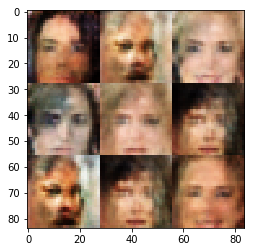

Step12210 Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 0.9403
Step12220 Epoch 1/1... Discriminator Loss: 1.0357... Generator Loss: 1.0779
Step12230 Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0669
Step12240 Epoch 1/1... Discriminator Loss: 0.7841... Generator Loss: 1.8336
Step12250 Epoch 1/1... Discriminator Loss: 0.8413... Generator Loss: 1.2136
Step12260 Epoch 1/1... Discriminator Loss: 0.9064... Generator Loss: 1.3267
Step12270 Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.2621
Step12280 Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.5879
Step12290 Epoch 1/1... Discriminator Loss: 0.8859... Generator Loss: 1.2430
Step12300 Epoch 1/1... Discriminator Loss: 1.0155... Generator Loss: 1.0196


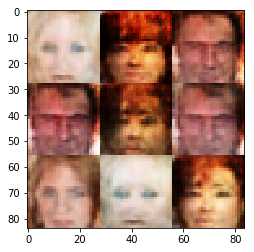

Step12310 Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.2572
Step12320 Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.0214
Step12330 Epoch 1/1... Discriminator Loss: 1.0380... Generator Loss: 0.9855
Step12340 Epoch 1/1... Discriminator Loss: 0.8752... Generator Loss: 1.0987
Step12350 Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.1060
Step12360 Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 1.0968
Step12370 Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 1.7604
Step12380 Epoch 1/1... Discriminator Loss: 0.9744... Generator Loss: 0.8974
Step12390 Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.6829
Step12400 Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.2173


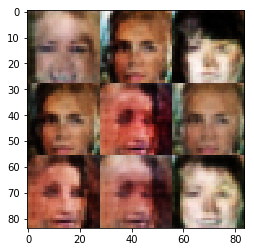

Step12410 Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.8296
Step12420 Epoch 1/1... Discriminator Loss: 0.7529... Generator Loss: 1.4699
Step12430 Epoch 1/1... Discriminator Loss: 0.7047... Generator Loss: 1.6152
Step12440 Epoch 1/1... Discriminator Loss: 0.8669... Generator Loss: 1.2723
Step12450 Epoch 1/1... Discriminator Loss: 0.9078... Generator Loss: 1.0194
Step12460 Epoch 1/1... Discriminator Loss: 0.7695... Generator Loss: 1.8086
Step12470 Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.3929
Step12480 Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 0.9352
Step12490 Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.4128
Step12500 Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.7745


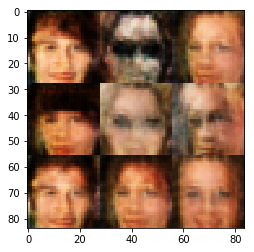

Step12510 Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 1.0405
Step12520 Epoch 1/1... Discriminator Loss: 0.9923... Generator Loss: 1.0591
Step12530 Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 0.7645
Step12540 Epoch 1/1... Discriminator Loss: 0.8260... Generator Loss: 1.2021
Step12550 Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 1.2665
Step12560 Epoch 1/1... Discriminator Loss: 1.2169... Generator Loss: 0.7230
Step12570 Epoch 1/1... Discriminator Loss: 1.0135... Generator Loss: 1.0005
Step12580 Epoch 1/1... Discriminator Loss: 0.8394... Generator Loss: 1.1801
Step12590 Epoch 1/1... Discriminator Loss: 1.0515... Generator Loss: 1.1126
Step12600 Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9950


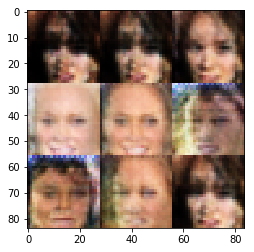

Step12610 Epoch 1/1... Discriminator Loss: 0.7542... Generator Loss: 1.8137
Step12620 Epoch 1/1... Discriminator Loss: 0.8304... Generator Loss: 1.4349
Step12630 Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 1.8077
Step12640 Epoch 1/1... Discriminator Loss: 0.9625... Generator Loss: 0.9458
Step12650 Epoch 1/1... Discriminator Loss: 0.9925... Generator Loss: 1.0811
Step12660 Epoch 1/1... Discriminator Loss: 0.8422... Generator Loss: 1.3116


In [58]:
batch_size = 16
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.